# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [71]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


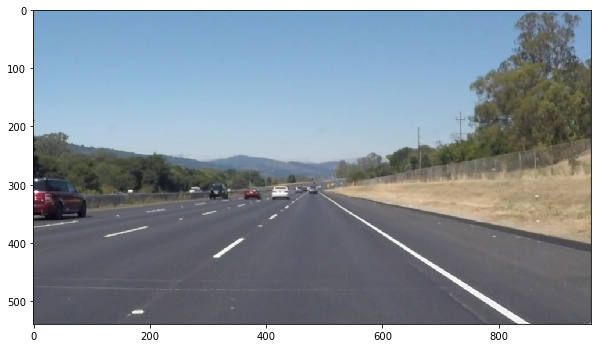

In [72]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [73]:
import math

def read_image(fname):
    """
    Reads file and returns image
    """
    if not os.path.isfile(fname):
        raise FileNotFoundError

    return mpimg.imread(fname)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def interpolate_line(x, y, startY, endY):
    """
    Does a linear regression on (x,y) and interpolates between
    startY and endY
    """
    from scipy import stats
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    xPos = lambda y,m,b : int(round((y - b) / m))
    
    startX = xPos(startY,slope,intercept)
    endX = xPos(endY,slope,intercept)
    
    return [(startX,startY), (endX,endY)]
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    leftLaneX = []
    leftLaneY = []
    
    rightLaneX = []
    rightLaneY = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # this works only as long as x2 and x1 are not equal!!!
            if math.fabs(x2 - x1) < 0.0001:
                continue
        
            slope = (y2 - y1) / (x2 - x1)
            
            if math.fabs(slope) < 0.1:
                print("Invalid slope x2:%d, x1:%d" % (x2,x1))
                continue
            
            if x1 > 450:
                rightLaneX.append(x1)
                rightLaneX.append(x2)
                rightLaneY.append(y1)
                rightLaneY.append(y2)                
            else:
                leftLaneX.append(x1)
                leftLaneX.append(x2)
                leftLaneY.append(y1)
                leftLaneY.append(y2)                
    
    if (len(leftLaneX) > 0 and len(leftLaneY) > 0):
        leftPoints = interpolate_line(leftLaneX, leftLaneY, img.shape[0], 330)
        cv2.line(img, leftPoints[0], leftPoints[1], color, thickness)
    
    if (len(rightLaneX) > 0 and len(rightLaneY) > 0):
        rightPoints = interpolate_line(rightLaneX, rightLaneY, img.shape[0], 330)
        cv2.line(img, rightPoints[0], rightPoints[1], color, thickness)

    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [74]:
import os
test_dir = 'test_images'
test_images = os.listdir(test_dir)


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [75]:
final_images = []

def create_roi(image):
    xsize =  image.shape[1]
    ysize =  image.shape[0]
    
    yRatio = 0.59
    xRatio = 0.17
    xRatioTop = 0.9375
    
    top = int(round(yRatio * ysize))
    xLenBottom = int(round(xRatio * xsize)/2)
    xLenTop = int(round(xRatioTop * xsize)/2)
    
    trap_left_bottom = (xLenBottom,ysize)
    trap_left_top = (xLenTop, top)
    trap_right_top = (xsize-xLenTop, top)
    trap_right_bottom = (xsize-xLenBottom,ysize)
    
    vertices = np.array([[trap_left_bottom, trap_left_top, trap_right_top, trap_right_bottom]], dtype=np.int32)
    
    roi_image = region_of_interest(image, vertices)
    
    return roi_image
    
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
for fname in test_images:
    
    print('new image: ' + fname)
    
    # Lane detection pipeline
    # 1.) Read image
    filePath = os.path.join(test_dir, fname)
    image = read_image(filePath)

    # 2.) Convert to Gray
    gray = grayscale(image)
    
    # 3.) Smooth image
    blur_gray = gaussian_blur(gray,kernel_size = 3)

    # 4.) Use canny and search for edges in ROI
    #edges = canny(roi_image, low_threshold = 100, high_threshold = 180)
    edges = canny(blur_gray, low_threshold = 100, high_threshold = 200)
    
    # 5.) Create a ROI using a trapezoid
    roi_image = create_roi(edges)
                              
    # 6.) Use hough transform to find lane lines
    line_image = hough_lines(np.copy(roi_image), rho=2, theta=np.pi/180, threshold=15, min_line_len=20, max_line_gap=10)
    
    # 7.)
    final_image = weighted_img(line_image, image)
    
    final_images.append(final_image)

new image: solidWhiteCurve.jpg
new image: solidWhiteRight.jpg
new image: solidYellowCurve.jpg
new image: solidYellowCurve2.jpg
new image: solidYellowLeft.jpg
new image: whiteCarLaneSwitch.jpg
Invalid slope x2:284, x1:260


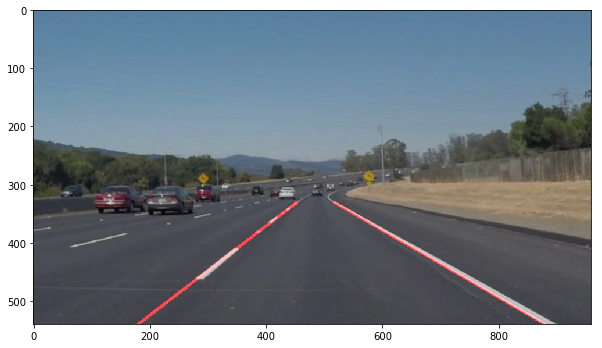

In [76]:
plt.imshow(final_images[0])

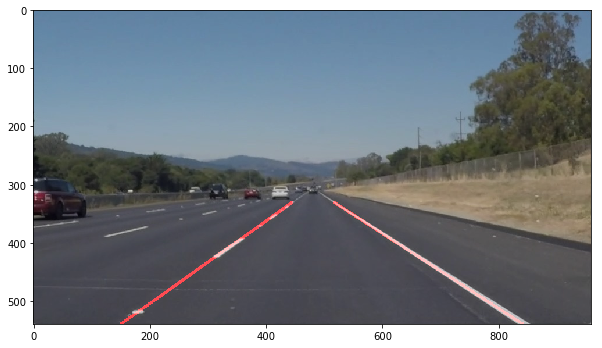

In [77]:
plt.imshow(final_images[1])

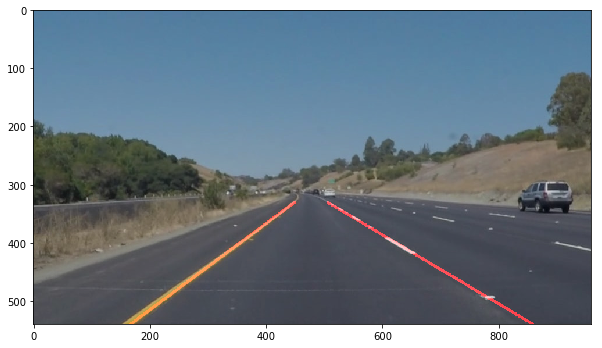

In [78]:
plt.imshow(final_images[2])

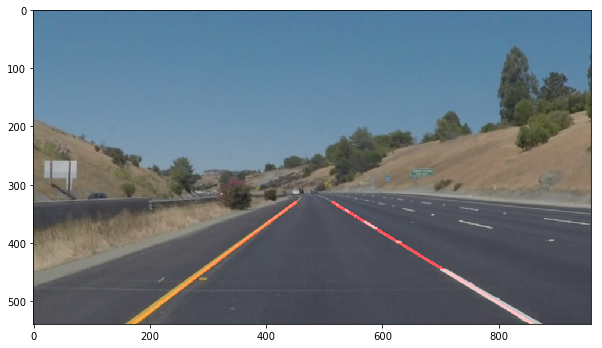

In [79]:
plt.imshow(final_images[3])

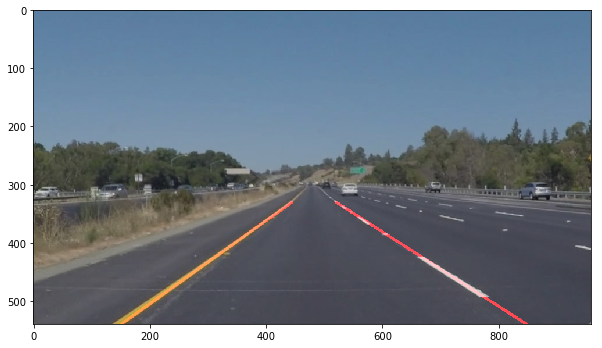

In [80]:
plt.imshow(final_images[4])

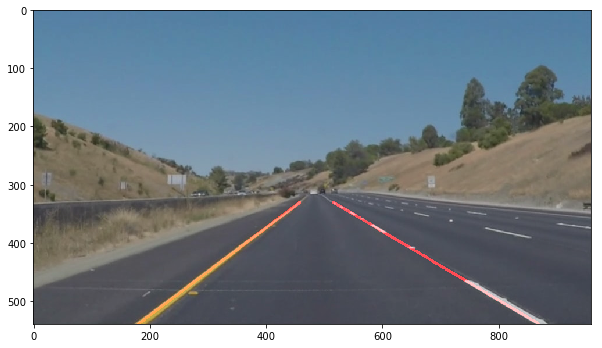

In [81]:
plt.imshow(final_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [82]:
#import imageio
#imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [83]:
counter = 0
base_dir = 'challenge_images'

def process_image(image):
    global counter
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
           
    # 2.) Convert to Gray
    gray = grayscale(image)
    
    #path = os.path.join(base_dir, 'image_' + str(counter) + '.jpg')
    #counter = counter + 1
    #cv2.imwrite(path, image)
    
    # 3.) Smooth image
    blur_gray = gaussian_blur(gray,kernel_size = 5)
    
    # 4.) Use canny and search for edges in ROI
    #edges = canny(roi_image, low_threshold = 100, high_threshold = 180)
    edges = canny(blur_gray, low_threshold = 100, high_threshold = 180)
    
    # 5.) Create a ROI using a trapezoid
    roi_image = create_roi(edges)
                              
    # 6.) Use hough transform to find lane lines
    line_image = hough_lines(np.copy(roi_image), rho=2, theta=np.pi/180, threshold=15, min_line_len=20, max_line_gap=10)
    
    # 7.)
    final_image = weighted_img(line_image, image)
    
    final_images.append(final_image)

    return final_image


Let's try the one with the solid white lane on the right first ...

In [84]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  9%|██████▉                                                                          | 19/222 [00:00<00:03, 54.65it/s]

Invalid slope x2:187, x1:165


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:03<00:00, 59.76it/s]

Invalid slope x2:510, x1:481


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 58.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4.24 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [85]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [86]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|▋                                                                                 | 6/682 [00:00<00:12, 54.08it/s]

Invalid slope x2:784, x1:760


  2%|█▌                                                                               | 13/682 [00:00<00:11, 57.86it/s]

Invalid slope x2:289, x1:267
Invalid slope x2:770, x1:750


  3%|██▍                                                                              | 21/682 [00:00<00:10, 60.76it/s]

Invalid slope x2:826, x1:799
Invalid slope x2:304, x1:284


  4%|███▎                                                                             | 28/682 [00:00<00:10, 61.00it/s]

Invalid slope x2:250, x1:229
Invalid slope x2:206, x1:183


  5%|████▎                                                                            | 36/682 [00:00<00:10, 63.28it/s]

Invalid slope x2:274, x1:254
Invalid slope x2:240, x1:216


  7%|█████▊                                                                           | 49/682 [00:00<00:10, 60.82it/s]

Invalid slope x2:288, x1:266
Invalid slope x2:258, x1:233


  9%|███████▎                                                                         | 62/682 [00:00<00:10, 60.48it/s]

Invalid slope x2:262, x1:238


 10%|████████                                                                         | 68/682 [00:01<00:10, 59.78it/s]

Invalid slope x2:763, x1:743


 11%|████████▉                                                                        | 75/682 [00:01<00:10, 60.40it/s]

Invalid slope x2:320, x1:299


 12%|█████████▌                                                                       | 81/682 [00:01<00:10, 58.84it/s]

Invalid slope x2:726, x1:706
Invalid slope x2:761, x1:741
Invalid slope x2:803, x1:782


 13%|██████████▎                                                                      | 87/682 [00:01<00:10, 57.88it/s]

Invalid slope x2:235, x1:211


 15%|███████████▋                                                                    | 100/682 [00:01<00:09, 59.04it/s]

Invalid slope x2:346, x1:317
Invalid slope x2:310, x1:286
Invalid slope x2:283, x1:260


 16%|████████████▍                                                                   | 106/682 [00:01<00:10, 57.11it/s]

Invalid slope x2:839, x1:816


 17%|█████████████▉                                                                  | 119/682 [00:01<00:09, 57.02it/s]

Invalid slope x2:728, x1:707
Invalid slope x2:763, x1:742
Invalid slope x2:812, x1:791
Invalid slope x2:814, x1:788


 18%|██████████████▋                                                                 | 125/682 [00:02<00:09, 56.24it/s]

Invalid slope x2:232, x1:202


 19%|███████████████▎                                                                | 131/682 [00:02<00:09, 56.34it/s]

Invalid slope x2:844, x1:817


 20%|████████████████                                                                | 137/682 [00:02<00:09, 56.16it/s]

Invalid slope x2:279, x1:257
Invalid slope x2:247, x1:226


 21%|████████████████▊                                                               | 143/682 [00:02<00:09, 55.81it/s]

Invalid slope x2:202, x1:177
Invalid slope x2:813, x1:788


 23%|██████████████████▍                                                             | 157/682 [00:02<00:09, 58.32it/s]

Invalid slope x2:506, x1:471
Invalid slope x2:800, x1:777
Invalid slope x2:864, x1:844
Invalid slope x2:862, x1:833


 24%|███████████████████                                                             | 163/682 [00:02<00:09, 57.12it/s]

Invalid slope x2:284, x1:264
Invalid slope x2:253, x1:229
Invalid slope x2:210, x1:181


 26%|████████████████████▌                                                           | 175/682 [00:02<00:08, 56.53it/s]

Invalid slope x2:311, x1:289
Invalid slope x2:284, x1:262
Invalid slope x2:285, x1:258


 27%|█████████████████████▉                                                          | 187/682 [00:03<00:09, 54.63it/s]

Invalid slope x2:350, x1:328
Invalid slope x2:293, x1:271


 29%|███████████████████████▍                                                        | 200/682 [00:03<00:08, 55.97it/s]

Invalid slope x2:233, x1:213


 30%|████████████████████████▏                                                       | 206/682 [00:03<00:08, 55.61it/s]

Invalid slope x2:499, x1:467


 31%|████████████████████████▊                                                       | 212/682 [00:03<00:08, 55.83it/s]

Invalid slope x2:847, x1:826
Invalid slope x2:237, x1:211


 32%|█████████████████████████▌                                                      | 218/682 [00:03<00:08, 55.82it/s]

Invalid slope x2:793, x1:771
Invalid slope x2:852, x1:822


 33%|██████████████████████████▎                                                     | 224/682 [00:03<00:08, 56.36it/s]

Invalid slope x2:319, x1:298
Invalid slope x2:273, x1:249


 34%|██████████████████████████▉                                                     | 230/682 [00:03<00:07, 57.14it/s]

Invalid slope x2:829, x1:804


 35%|███████████████████████████▊                                                    | 237/682 [00:04<00:07, 58.42it/s]

Invalid slope x2:204, x1:184


 38%|██████████████████████████████                                                  | 256/682 [00:04<00:07, 58.60it/s]

Invalid slope x2:816, x1:793
Invalid slope x2:775, x1:755
Invalid slope x2:829, x1:804


 38%|██████████████████████████████▋                                                 | 262/682 [00:04<00:07, 58.74it/s]

Invalid slope x2:276, x1:253


 39%|███████████████████████████████▌                                                | 269/682 [00:04<00:06, 59.81it/s]

Invalid slope x2:770, x1:750
Invalid slope x2:508, x1:488


 40%|████████████████████████████████▎                                               | 275/682 [00:04<00:06, 59.76it/s]

Invalid slope x2:333, x1:304
Invalid slope x2:374, x1:354
Invalid slope x2:391, x1:347


 41%|████████████████████████████████▉                                               | 281/682 [00:04<00:06, 57.66it/s]

Invalid slope x2:395, x1:363
Invalid slope x2:219, x1:199
Invalid slope x2:370, x1:337
Invalid slope x2:395, x1:371
Invalid slope x2:377, x1:355
Invalid slope x2:389, x1:350
Invalid slope x2:376, x1:355
Invalid slope x2:371, x1:328
Invalid slope x2:373, x1:320
Invalid slope x2:296, x1:274
Invalid slope x2:504, x1:481
Invalid slope x2:874, x1:854
Invalid slope x2:866, x1:844


 42%|█████████████████████████████████▋                                              | 287/682 [00:04<00:07, 53.34it/s]

Invalid slope x2:302, x1:280
Invalid slope x2:293, x1:251
Invalid slope x2:504, x1:482
Invalid slope x2:503, x1:479
Invalid slope x2:358, x1:338
Invalid slope x2:271, x1:237
Invalid slope x2:275, x1:249
Invalid slope x2:332, x1:296
Invalid slope x2:311, x1:269
Invalid slope x2:293, x1:265
Invalid slope x2:235, x1:207
Invalid slope x2:259, x1:231
Invalid slope x2:279, x1:228
Invalid slope x2:207, x1:183
Invalid slope x2:517, x1:488
Invalid slope x2:282, x1:261
Invalid slope x2:204, x1:178
Invalid slope x2:142, x1:118
Invalid slope x2:240, x1:215
Invalid slope x2:214, x1:184
Invalid slope x2:149, x1:102
Invalid slope x2:153, x1:133
Invalid slope x2:131, x1:100
Invalid slope x2:502, x1:479
Invalid slope x2:269, x1:244


 43%|██████████████████████████████████▎                                             | 293/682 [00:05<00:08, 45.44it/s]

Invalid slope x2:231, x1:207
Invalid slope x2:502, x1:481
Invalid slope x2:846, x1:824


 44%|███████████████████████████████████                                             | 299/682 [00:05<00:07, 48.52it/s]

Invalid slope x2:338, x1:316
Invalid slope x2:338, x1:312
Invalid slope x2:302, x1:281
Invalid slope x2:276, x1:253


 45%|███████████████████████████████████▊                                            | 305/682 [00:05<00:07, 51.13it/s]

Invalid slope x2:240, x1:215
Invalid slope x2:780, x1:759


 46%|████████████████████████████████████▍                                           | 311/682 [00:05<00:06, 53.42it/s]

Invalid slope x2:284, x1:261


 46%|█████████████████████████████████████▏                                          | 317/682 [00:05<00:06, 54.70it/s]

Invalid slope x2:250, x1:229
Invalid slope x2:209, x1:183
Invalid slope x2:772, x1:751
Invalid slope x2:824, x1:799


 49%|███████████████████████████████████████▎                                        | 335/682 [00:05<00:06, 56.12it/s]

Invalid slope x2:331, x1:302


 50%|████████████████████████████████████████                                        | 342/682 [00:05<00:05, 57.73it/s]

Invalid slope x2:224, x1:201
Invalid slope x2:862, x1:833


 51%|████████████████████████████████████████▉                                       | 349/682 [00:06<00:05, 58.92it/s]

Invalid slope x2:346, x1:322
Invalid slope x2:268, x1:247
Invalid slope x2:232, x1:208


 52%|█████████████████████████████████████████▋                                      | 355/682 [00:06<00:05, 58.70it/s]

Invalid slope x2:181, x1:159
Invalid slope x2:847, x1:822


 53%|██████████████████████████████████████████▎                                     | 361/682 [00:06<00:05, 56.81it/s]

Invalid slope x2:321, x1:294
Invalid slope x2:242, x1:216


 54%|███████████████████████████████████████████                                     | 367/682 [00:06<00:05, 56.97it/s]

Invalid slope x2:195, x1:164


 55%|███████████████████████████████████████████▊                                    | 374/682 [00:06<00:05, 59.48it/s]

Invalid slope x2:322, x1:294
Invalid slope x2:277, x1:257


 57%|█████████████████████████████████████████████▍                                  | 387/682 [00:06<00:04, 59.74it/s]

Invalid slope x2:200, x1:173


 60%|███████████████████████████████████████████████▊                                | 408/682 [00:07<00:04, 60.53it/s]

Invalid slope x2:322, x1:299


 61%|████████████████████████████████████████████████▋                               | 415/682 [00:07<00:04, 61.58it/s]

Invalid slope x2:780, x1:759
Invalid slope x2:841, x1:815


 62%|█████████████████████████████████████████████████▌                              | 422/682 [00:07<00:04, 61.75it/s]

Invalid slope x2:272, x1:249
Invalid slope x2:791, x1:769


 63%|██████████████████████████████████████████████████▎                             | 429/682 [00:07<00:04, 61.31it/s]

Invalid slope x2:807, x1:784
Invalid slope x2:332, x1:311


 64%|███████████████████████████████████████████████████▏                            | 436/682 [00:07<00:03, 61.65it/s]

Invalid slope x2:294, x1:271
Invalid slope x2:236, x1:212
Invalid slope x2:813, x1:790
Invalid slope x2:186, x1:166


 66%|████████████████████████████████████████████████████▊                           | 450/682 [00:07<00:03, 58.56it/s]

Invalid slope x2:278, x1:255


 67%|█████████████████████████████████████████████████████▌                          | 457/682 [00:07<00:03, 58.92it/s]

Invalid slope x2:324, x1:296


 70%|████████████████████████████████████████████████████████                        | 478/682 [00:08<00:03, 61.09it/s]

Invalid slope x2:777, x1:756
Invalid slope x2:776, x1:754


 71%|████████████████████████████████████████████████████████▉                       | 485/682 [00:08<00:03, 60.30it/s]

Invalid slope x2:311, x1:290
Invalid slope x2:195, x1:172


 72%|█████████████████████████████████████████████████████████▋                      | 492/682 [00:08<00:03, 59.38it/s]

Invalid slope x2:817, x1:794
Invalid slope x2:346, x1:326


 73%|██████████████████████████████████████████████████████████▍                     | 498/682 [00:08<00:03, 58.76it/s]

Invalid slope x2:209, x1:185


 74%|███████████████████████████████████████████████████████████                     | 504/682 [00:08<00:03, 59.03it/s]

Invalid slope x2:803, x1:778


 75%|███████████████████████████████████████████████████████████▊                    | 510/682 [00:08<00:03, 56.69it/s]

Invalid slope x2:840, x1:820
Invalid slope x2:221, x1:195


 76%|████████████████████████████████████████████████████████████▌                   | 516/682 [00:08<00:02, 57.14it/s]

Invalid slope x2:787, x1:761
Invalid slope x2:785, x1:764


 77%|█████████████████████████████████████████████████████████████▏                  | 522/682 [00:09<00:02, 55.85it/s]

Invalid slope x2:272, x1:250
Invalid slope x2:192, x1:169


 80%|████████████████████████████████████████████████████████████████▎               | 548/682 [00:09<00:02, 59.60it/s]

Invalid slope x2:842, x1:820


 82%|█████████████████████████████████████████████████████████████████▉              | 562/682 [00:09<00:01, 60.73it/s]

Invalid slope x2:259, x1:237
Invalid slope x2:216, x1:193
Invalid slope x2:212, x1:189


 83%|██████████████████████████████████████████████████████████████████▋             | 569/682 [00:09<00:01, 59.06it/s]

Invalid slope x2:310, x1:290


 86%|████████████████████████████████████████████████████████████████████▉           | 588/682 [00:10<00:01, 59.83it/s]

Invalid slope x2:223, x1:193
Invalid slope x2:223, x1:197
Invalid slope x2:218, x1:198


 87%|█████████████████████████████████████████████████████████████████████▋          | 594/682 [00:10<00:01, 59.51it/s]

Invalid slope x2:308, x1:287


 89%|███████████████████████████████████████████████████████████████████████▎        | 608/682 [00:10<00:01, 61.57it/s]

Invalid slope x2:344, x1:311


 91%|████████████████████████████████████████████████████████████████████████▉       | 622/682 [00:10<00:00, 61.86it/s]

Invalid slope x2:289, x1:269
Invalid slope x2:252, x1:230


 94%|███████████████████████████████████████████████████████████████████████████▍    | 643/682 [00:10<00:00, 62.20it/s]

Invalid slope x2:298, x1:275
Invalid slope x2:270, x1:248
Invalid slope x2:270, x1:245


 95%|████████████████████████████████████████████████████████████████████████████▏   | 650/682 [00:11<00:00, 61.21it/s]

Invalid slope x2:228, x1:207


 96%|█████████████████████████████████████████████████████████████████████████████   | 657/682 [00:11<00:00, 61.58it/s]

Invalid slope x2:299, x1:277


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 671/682 [00:11<00:00, 62.42it/s]

Invalid slope x2:306, x1:283
Invalid slope x2:722, x1:694
Invalid slope x2:719, x1:695
Invalid slope x2:765, x1:745
Invalid slope x2:814, x1:786
Invalid slope x2:830, x1:803


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:11<00:00, 58.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 12 s


In [87]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [88]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Invalid slope x2:972, x1:935
Invalid slope x2:409, x1:276
Invalid slope x2:840, x1:791
Invalid slope x2:653, x1:625
Invalid slope x2:539, x1:510
Invalid slope x2:624, x1:603
Invalid slope x2:1070, x1:1007
Invalid slope x2:572, x1:535
Invalid slope x2:237, x1:190
Invalid slope x2:918, x1:853
Invalid slope x2:490, x1:469
Invalid slope x2:593, x1:573
Invalid slope x2:678, x1:654
Invalid slope x2:700, x1:679
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

Invalid slope x2:972, x1:935
Invalid slope x2:409, x1:276
Invalid slope x2:840, x1:791
Invalid slope x2:653, x1:625
Invalid slope x2:539, x1:510
Invalid slope x2:624, x1:603
Invalid slope x2:1070, x1:1007
Invalid slope x2:572, x1:535
Invalid slope x2:237, x1:190
Invalid slope x2:918, x1:853
Invalid slope x2:490, x1:469
Invalid slope x2:593, x1:573
Invalid slope x2:678, x1:654
Invalid slope x2:700, x1:679
Invalid slope x2:747, x1:633
Invalid slope x2:407, x1:347
Invalid slope x2:899, x1:850
Invalid slope x2:572, x1:520
Invalid slope x2:287, x1:267
Invalid slope x2:1024, x1:976
Invalid slope x2:938, x1:891
Invalid slope x2:317, x1:281
Invalid slope x2:228, x1:199
Invalid slope x2:811, x1:759
Invalid slope x2:269, x1:247
Invalid slope x2:628, x1:600
Invalid slope x2:849, x1:812
Invalid slope x2:490, x1:429
Invalid slope x2:246, x1:200
Invalid slope x2:505, x1:482


  1%|▋                                                                                 | 2/251 [00:00<00:16, 14.90it/s]

Invalid slope x2:725, x1:646
Invalid slope x2:788, x1:765
Invalid slope x2:1086, x1:949
Invalid slope x2:543, x1:439
Invalid slope x2:348, x1:281
Invalid slope x2:581, x1:553
Invalid slope x2:913, x1:825
Invalid slope x2:398, x1:375
Invalid slope x2:960, x1:914
Invalid slope x2:645, x1:619
Invalid slope x2:684, x1:657
Invalid slope x2:281, x1:253
Invalid slope x2:244, x1:221
Invalid slope x2:598, x1:560
Invalid slope x2:1081, x1:974
Invalid slope x2:793, x1:765
Invalid slope x2:493, x1:368
Invalid slope x2:289, x1:242
Invalid slope x2:676, x1:645
Invalid slope x2:819, x1:794
Invalid slope x2:906, x1:872
Invalid slope x2:229, x1:208
Invalid slope x2:542, x1:520
Invalid slope x2:377, x1:343
Invalid slope x2:973, x1:938
Invalid slope x2:743, x1:707
Invalid slope x2:847, x1:825
Invalid slope x2:315, x1:283
Invalid slope x2:623, x1:599
Invalid slope x2:241, x1:201
Invalid slope x2:470, x1:422
Invalid slope x2:518, x1:497
Invalid slope x2:684, x1:662


  2%|█▎                                                                                | 4/251 [00:00<00:16, 14.65it/s]

Invalid slope x2:326, x1:264
Invalid slope x2:789, x1:719
Invalid slope x2:1082, x1:959
Invalid slope x2:429, x1:408
Invalid slope x2:485, x1:438
Invalid slope x2:583, x1:486
Invalid slope x2:936, x1:822
Invalid slope x2:661, x1:624
Invalid slope x2:373, x1:347
Invalid slope x2:399, x1:374
Invalid slope x2:240, x1:188
Invalid slope x2:683, x1:649
Invalid slope x2:923, x1:902
Invalid slope x2:232, x1:209
Invalid slope x2:561, x1:541
Invalid slope x2:450, x1:430
Invalid slope x2:677, x1:649
Invalid slope x2:411, x1:345
Invalid slope x2:589, x1:533
Invalid slope x2:1044, x1:942
Invalid slope x2:310, x1:268
Invalid slope x2:823, x1:775
Invalid slope x2:1067, x1:1047
Invalid slope x2:235, x1:203
Invalid slope x2:921, x1:865
Invalid slope x2:632, x1:604
Invalid slope x2:732, x1:704
Invalid slope x2:883, x1:850
Invalid slope x2:615, x1:595
Invalid slope x2:685, x1:665


  2%|█▉                                                                                | 6/251 [00:00<00:16, 14.43it/s]

Invalid slope x2:751, x1:634
Invalid slope x2:568, x1:540
Invalid slope x2:792, x1:764
Invalid slope x2:1076, x1:989
Invalid slope x2:344, x1:309
Invalid slope x2:518, x1:462
Invalid slope x2:1020, x1:998
Invalid slope x2:285, x1:220
Invalid slope x2:847, x1:809
Invalid slope x2:399, x1:374
Invalid slope x2:960, x1:927
Invalid slope x2:601, x1:579
Invalid slope x2:379, x1:345
Invalid slope x2:909, x1:886
Invalid slope x2:985, x1:961
Invalid slope x2:537, x1:515
Invalid slope x2:902, x1:881
Invalid slope x2:546, x1:522
Invalid slope x2:770, x1:742
Invalid slope x2:327, x1:269
Invalid slope x2:1079, x1:974
Invalid slope x2:421, x1:362
Invalid slope x2:656, x1:571
Invalid slope x2:827, x1:790
Invalid slope x2:973, x1:951
Invalid slope x2:504, x1:482
Invalid slope x2:929, x1:838
Invalid slope x2:454, x1:429
Invalid slope x2:230, x1:200
Invalid slope x2:741, x1:714
Invalid slope x2:801, x1:773
Invalid slope x2:242, x1:216
Invalid slope x2:539, x1:519


  3%|██▌                                                                               | 8/251 [00:00<00:16, 14.63it/s]

Invalid slope x2:758, x1:629
Invalid slope x2:358, x1:290
Invalid slope x2:1079, x1:987
Invalid slope x2:490, x1:365
Invalid slope x2:868, x1:816
Invalid slope x2:266, x1:239
Invalid slope x2:950, x1:891
Invalid slope x2:613, x1:491
Invalid slope x2:682, x1:651
Invalid slope x2:774, x1:752
Invalid slope x2:233, x1:202
Invalid slope x2:899, x1:841
Invalid slope x2:220, x1:196
Invalid slope x2:444, x1:421
Invalid slope x2:810, x1:755
Invalid slope x2:601, x1:545
Invalid slope x2:1080, x1:977
Invalid slope x2:324, x1:282
Invalid slope x2:724, x1:696
Invalid slope x2:468, x1:384
Invalid slope x2:953, x1:919
Invalid slope x2:693, x1:637
Invalid slope x2:238, x1:204
Invalid slope x2:524, x1:501
Invalid slope x2:843, x1:811
Invalid slope x2:281, x1:230
Invalid slope x2:544, x1:514
Invalid slope x2:913, x1:890
Invalid slope x2:368, x1:336
Invalid slope x2:500, x1:480
Invalid slope x2:678, x1:649
Invalid slope x2:510, x1:480


  4%|███▏                                                                             | 10/251 [00:00<00:16, 14.40it/s]

Invalid slope x2:310, x1:254
Invalid slope x2:634, x1:455
Invalid slope x2:794, x1:738
Invalid slope x2:1083, x1:954
Invalid slope x2:383, x1:359
Invalid slope x2:880, x1:824
Invalid slope x2:214, x1:193
Invalid slope x2:689, x1:662
Invalid slope x2:670, x1:637
Invalid slope x2:343, x1:321
Invalid slope x2:771, x1:620
Invalid slope x2:520, x1:470
Invalid slope x2:394, x1:371
Invalid slope x2:1082, x1:954
Invalid slope x2:295, x1:241
Invalid slope x2:889, x1:844
Invalid slope x2:237, x1:202
Invalid slope x2:370, x1:340
Invalid slope x2:617, x1:589
Invalid slope x2:675, x1:650
Invalid slope x2:339, x1:301
Invalid slope x2:926, x1:902
Invalid slope x2:801, x1:768


  5%|███▊                                                                             | 12/251 [00:00<00:15, 15.24it/s]

Invalid slope x2:375, x1:314
Invalid slope x2:727, x1:648
Invalid slope x2:1085, x1:960
Invalid slope x2:579, x1:523
Invalid slope x2:297, x1:219
Invalid slope x2:903, x1:829
Invalid slope x2:788, x1:746
Invalid slope x2:629, x1:601
Invalid slope x2:949, x1:913
Invalid slope x2:488, x1:461
Invalid slope x2:745, x1:715
Invalid slope x2:673, x1:649
Invalid slope x2:660, x1:631
Invalid slope x2:804, x1:740
Invalid slope x2:550, x1:431
Invalid slope x2:624, x1:587
Invalid slope x2:998, x1:961
Invalid slope x2:328, x1:258
Invalid slope x2:400, x1:377
Invalid slope x2:932, x1:841
Invalid slope x2:257, x1:223
Invalid slope x2:1090, x1:1011
Invalid slope x2:725, x1:687
Invalid slope x2:379, x1:351
Invalid slope x2:645, x1:625
Invalid slope x2:840, x1:805
Invalid slope x2:673, x1:644


  6%|████▌                                                                            | 14/251 [00:00<00:15, 15.00it/s]

Invalid slope x2:759, x1:630
Invalid slope x2:1083, x1:991
Invalid slope x2:519, x1:469
Invalid slope x2:569, x1:513
Invalid slope x2:405, x1:363
Invalid slope x2:843, x1:814
Invalid slope x2:906, x1:844
Invalid slope x2:813, x1:772
Invalid slope x2:990, x1:951
Invalid slope x2:290, x1:212
Invalid slope x2:601, x1:573
Invalid slope x2:369, x1:343
Invalid slope x2:673, x1:646
Invalid slope x2:598, x1:563
Invalid slope x2:861, x1:792
Invalid slope x2:300, x1:270
Invalid slope x2:1080, x1:974
Invalid slope x2:493, x1:368
Invalid slope x2:958, x1:917
Invalid slope x2:645, x1:611
Invalid slope x2:416, x1:392
Invalid slope x2:234, x1:199
Invalid slope x2:538, x1:505
Invalid slope x2:742, x1:720
Invalid slope x2:470, x1:423
Invalid slope x2:669, x1:642


  6%|█████▏                                                                           | 16/251 [00:01<00:15, 15.16it/s]

Invalid slope x2:787, x1:608
Invalid slope x2:958, x1:912
Invalid slope x2:383, x1:324
Invalid slope x2:1084, x1:1030
Invalid slope x2:521, x1:442
Invalid slope x2:260, x1:217
Invalid slope x2:844, x1:807
Invalid slope x2:1017, x1:989
Invalid slope x2:552, x1:524
Invalid slope x2:295, x1:275
Invalid slope x2:911, x1:885
Invalid slope x2:659, x1:639
Invalid slope x2:276, x1:242
Invalid slope x2:797, x1:733
Invalid slope x2:478, x1:447
Invalid slope x2:960, x1:914
Invalid slope x2:553, x1:514
Invalid slope x2:593, x1:559
Invalid slope x2:643, x1:606
Invalid slope x2:1028, x1:972
Invalid slope x2:859, x1:839
Invalid slope x2:412, x1:392
Invalid slope x2:391, x1:370
Invalid slope x2:241, x1:216
Invalid slope x2:1078, x1:1029
Invalid slope x2:971, x1:950
Invalid slope x2:501, x1:479
Invalid slope x2:975, x1:954
Invalid slope x2:660, x1:625


  7%|█████▊                                                                           | 18/251 [00:01<00:14, 15.61it/s]

Invalid slope x2:545, x1:428
Invalid slope x2:405, x1:370
Invalid slope x2:840, x1:795
Invalid slope x2:739, x1:683
Invalid slope x2:341, x1:301
Invalid slope x2:1082, x1:1036
Invalid slope x2:608, x1:560
Invalid slope x2:920, x1:855
Invalid slope x2:1035, x1:998
Invalid slope x2:244, x1:201
Invalid slope x2:1030, x1:1007
Invalid slope x2:655, x1:632
Invalid slope x2:372, x1:342
Invalid slope x2:1083, x1:958
Invalid slope x2:331, x1:304
Invalid slope x2:630, x1:574
Invalid slope x2:504, x1:479
Invalid slope x2:772, x1:659
Invalid slope x2:544, x1:519
Invalid slope x2:937, x1:824
Invalid slope x2:282, x1:230
Invalid slope x2:353, x1:332
Invalid slope x2:961, x1:938


  8%|██████▍                                                                          | 20/251 [00:01<00:14, 16.16it/s]

Invalid slope x2:779, x1:751
Invalid slope x2:606, x1:536
Invalid slope x2:710, x1:654
Invalid slope x2:402, x1:382
Invalid slope x2:957, x1:914
Invalid slope x2:328, x1:299
Invalid slope x2:541, x1:512
Invalid slope x2:836, x1:800
Invalid slope x2:1039, x1:983
Invalid slope x2:469, x1:411
Invalid slope x2:262, x1:221
Invalid slope x2:1091, x1:1062
Invalid slope x2:358, x1:321
Invalid slope x2:511, x1:488
Invalid slope x2:982, x1:958
Invalid slope x2:661, x1:631
Invalid slope x2:653, x1:448
Invalid slope x2:986, x1:917
Invalid slope x2:784, x1:756
Invalid slope x2:275, x1:220
Invalid slope x2:1027, x1:987
Invalid slope x2:831, x1:785
Invalid slope x2:721, x1:693
Invalid slope x2:1088, x1:1061
Invalid slope x2:373, x1:345
Invalid slope x2:344, x1:318
Invalid slope x2:656, x1:629
Invalid slope x2:317, x1:295
Invalid slope x2:294, x1:272


  9%|███████                                                                          | 22/251 [00:01<00:14, 16.18it/s]

Invalid slope x2:313, x1:283
Invalid slope x2:591, x1:551
Invalid slope x2:519, x1:492
Invalid slope x2:972, x1:915
Invalid slope x2:831, x1:775
Invalid slope x2:646, x1:609
Invalid slope x2:735, x1:707
Invalid slope x2:1039, x1:983
Invalid slope x2:257, x1:213
Invalid slope x2:462, x1:427
Invalid slope x2:673, x1:647
Invalid slope x2:388, x1:360
Invalid slope x2:697, x1:647
Invalid slope x2:359, x1:335
Invalid slope x2:911, x1:879
Invalid slope x2:657, x1:631
Invalid slope x2:489, x1:469
Invalid slope x2:756, x1:628
Invalid slope x2:1077, x1:972
Invalid slope x2:334, x1:262
Invalid slope x2:433, x1:376
Invalid slope x2:487, x1:445
Invalid slope x2:831, x1:803
Invalid slope x2:245, x1:204
Invalid slope x2:952, x1:916
Invalid slope x2:548, x1:515
Invalid slope x2:670, x1:643
Invalid slope x2:603, x1:575
Invalid slope x2:358, x1:326
Invalid slope x2:878, x1:841
Invalid slope x2:787, x1:753
Invalid slope x2:280, x1:252


 10%|███████▋                                                                         | 24/251 [00:01<00:14, 16.15it/s]

Invalid slope x2:786, x1:679
Invalid slope x2:356, x1:281
Invalid slope x2:1035, x1:944
Invalid slope x2:619, x1:462
Invalid slope x2:280, x1:252
Invalid slope x2:855, x1:825
Invalid slope x2:219, x1:194
Invalid slope x2:405, x1:358
Invalid slope x2:645, x1:620
Invalid slope x2:823, x1:787
Invalid slope x2:664, x1:637
Invalid slope x2:1069, x1:1036
Invalid slope x2:681, x1:659
Invalid slope x2:649, x1:629
Invalid slope x2:820, x1:765
Invalid slope x2:569, x1:513
Invalid slope x2:1026, x1:936
Invalid slope x2:486, x1:427
Invalid slope x2:690, x1:634
Invalid slope x2:370, x1:298
Invalid slope x2:923, x1:876
Invalid slope x2:225, x1:203
Invalid slope x2:630, x1:602
Invalid slope x2:1089, x1:1051
Invalid slope x2:271, x1:238
Invalid slope x2:850, x1:821
Invalid slope x2:670, x1:641
Invalid slope x2:515, x1:491
Invalid slope x2:668, x1:624
Invalid slope x2:1050, x1:1027


 10%|████████▍                                                                        | 26/251 [00:01<00:13, 16.29it/s]

Invalid slope x2:625, x1:466
Invalid slope x2:1084, x1:968
Invalid slope x2:860, x1:800
Invalid slope x2:401, x1:268
Invalid slope x2:717, x1:685
Invalid slope x2:244, x1:207
Invalid slope x2:465, x1:441
Invalid slope x2:1066, x1:953
Invalid slope x2:819, x1:753
Invalid slope x2:325, x1:269
Invalid slope x2:428, x1:367
Invalid slope x2:941, x1:862
Invalid slope x2:709, x1:653
Invalid slope x2:647, x1:460
Invalid slope x2:243, x1:193
Invalid slope x2:689, x1:669
Invalid slope x2:355, x1:333
Invalid slope x2:668, x1:617
Invalid slope x2:847, x1:820
Invalid slope x2:650, x1:621
Invalid slope x2:896, x1:869
Invalid slope x2:761, x1:623
Invalid slope x2:1004, x1:934
Invalid slope x2:326, x1:284
Invalid slope x2:821, x1:782
Invalid slope x2:562, x1:520
Invalid slope x2:501, x1:364
Invalid slope x2:466, x1:421
Invalid slope x2:246, x1:202
Invalid slope x2:871, x1:843
Invalid slope x2:689, x1:667
Invalid slope x2:1055, x1:999
Invalid slope x2:606, x1:578
Invalid slope x2:656, x1:625
Invalid sl

 12%|█████████▎                                                                       | 29/251 [00:01<00:13, 17.05it/s]

Invalid slope x2:404, x1:258
Invalid slope x2:743, x1:638
Invalid slope x2:1082, x1:973
Invalid slope x2:939, x1:899
Invalid slope x2:842, x1:801
Invalid slope x2:518, x1:447
Invalid slope x2:690, x1:663
Invalid slope x2:231, x1:202
Invalid slope x2:670, x1:614
Invalid slope x2:614, x1:586
Invalid slope x2:907, x1:862
Invalid slope x2:972, x1:950
Invalid slope x2:1082, x1:948
Invalid slope x2:408, x1:328
Invalid slope x2:527, x1:431
Invalid slope x2:787, x1:706
Invalid slope x2:649, x1:626
Invalid slope x2:1031, x1:1008
Invalid slope x2:930, x1:895
Invalid slope x2:681, x1:644
Invalid slope x2:645, x1:619
Invalid slope x2:249, x1:219
Invalid slope x2:569, x1:539
Invalid slope x2:1039, x1:1016
Invalid slope x2:677, x1:611
Invalid slope x2:703, x1:682
Invalid slope x2:623, x1:595
Invalid slope x2:289, x1:254
Invalid slope x2:637, x1:614


 12%|██████████                                                                       | 31/251 [00:01<00:13, 16.92it/s]

Invalid slope x2:1018, x1:927
Invalid slope x2:411, x1:388
Invalid slope x2:589, x1:521
Invalid slope x2:267, x1:216
Invalid slope x2:344, x1:322
Invalid slope x2:807, x1:763
Invalid slope x2:673, x1:617
Invalid slope x2:657, x1:601
Invalid slope x2:922, x1:876
Invalid slope x2:375, x1:353
Invalid slope x2:500, x1:426
Invalid slope x2:1087, x1:1058
Invalid slope x2:850, x1:819
Invalid slope x2:322, x1:273
Invalid slope x2:527, x1:501
Invalid slope x2:514, x1:490
Invalid slope x2:1061, x1:1040
Invalid slope x2:1039, x1:1019
Invalid slope x2:1079, x1:989
Invalid slope x2:632, x1:589
Invalid slope x2:808, x1:710
Invalid slope x2:519, x1:470
Invalid slope x2:342, x1:319
Invalid slope x2:934, x1:844
Invalid slope x2:540, x1:513
Invalid slope x2:678, x1:609
Invalid slope x2:286, x1:242
Invalid slope x2:230, x1:188
Invalid slope x2:640, x1:609
Invalid slope x2:864, x1:831
Invalid slope x2:514, x1:483
Invalid slope x2:685, x1:662


 13%|██████████▋                                                                      | 33/251 [00:02<00:13, 16.24it/s]

Invalid slope x2:753, x1:630
Invalid slope x2:483, x1:414
Invalid slope x2:1077, x1:1035
Invalid slope x2:796, x1:768
Invalid slope x2:343, x1:313
Invalid slope x2:898, x1:865
Invalid slope x2:557, x1:516
Invalid slope x2:245, x1:223
Invalid slope x2:1086, x1:1060
Invalid slope x2:958, x1:925
Invalid slope x2:672, x1:634
Invalid slope x2:836, x1:799
Invalid slope x2:629, x1:602
Invalid slope x2:420, x1:398
Invalid slope x2:1020, x1:993
Invalid slope x2:879, x1:837
Invalid slope x2:639, x1:583
Invalid slope x2:1083, x1:946
Invalid slope x2:401, x1:333
Invalid slope x2:680, x1:647
Invalid slope x2:837, x1:815
Invalid slope x2:549, x1:493
Invalid slope x2:781, x1:730
Invalid slope x2:694, x1:671
Invalid slope x2:704, x1:648
Invalid slope x2:631, x1:607
Invalid slope x2:814, x1:787
Invalid slope x2:582, x1:531
Invalid slope x2:265, x1:239
Invalid slope x2:627, x1:604
Invalid slope x2:666, x1:620
Invalid slope x2:1022, x1:1002
Invalid slope x2:479, x1:456


 14%|███████████▎                                                                     | 35/251 [00:02<00:13, 15.81it/s]

Invalid slope x2:1064, x1:946
Invalid slope x2:763, x1:735
Invalid slope x2:559, x1:531
Invalid slope x2:852, x1:771
Invalid slope x2:640, x1:603
Invalid slope x2:278, x1:204
Invalid slope x2:391, x1:357
Invalid slope x2:674, x1:642
Invalid slope x2:620, x1:600
Invalid slope x2:495, x1:472
Invalid slope x2:682, x1:641
Invalid slope x2:674, x1:651
Invalid slope x2:356, x1:329
Invalid slope x2:1097, x1:1065
Invalid slope x2:618, x1:598
Invalid slope x2:945, x1:911
Invalid slope x2:350, x1:322
Invalid slope x2:744, x1:634
Invalid slope x2:990, x1:920
Invalid slope x2:467, x1:383
Invalid slope x2:680, x1:598
Invalid slope x2:1056, x1:1030
Invalid slope x2:694, x1:673
Invalid slope x2:639, x1:595
Invalid slope x2:600, x1:572
Invalid slope x2:633, x1:598
Invalid slope x2:239, x1:201
Invalid slope x2:914, x1:882
Invalid slope x2:379, x1:337
Invalid slope x2:1022, x1:994
Invalid slope x2:1084, x1:1061
Invalid slope x2:280, x1:250
Invalid slope x2:556, x1:532


 15%|███████████▉                                                                     | 37/251 [00:02<00:13, 15.35it/s]

Invalid slope x2:748, x1:692
Invalid slope x2:777, x1:742
Invalid slope x2:981, x1:917
Invalid slope x2:414, x1:337
Invalid slope x2:263, x1:226
Invalid slope x2:635, x1:597
Invalid slope x2:646, x1:594
Invalid slope x2:1012, x1:967
Invalid slope x2:1046, x1:1018
Invalid slope x2:680, x1:600
Invalid slope x2:490, x1:429
Invalid slope x2:1074, x1:1047
Invalid slope x2:862, x1:838
Invalid slope x2:520, x1:498
Invalid slope x2:331, x1:310
Invalid slope x2:286, x1:262
Invalid slope x2:633, x1:596
Invalid slope x2:879, x1:855
Invalid slope x2:725, x1:647
Invalid slope x2:257, x1:225
Invalid slope x2:979, x1:916
Invalid slope x2:818, x1:762
Invalid slope x2:374, x1:312
Invalid slope x2:533, x1:510
Invalid slope x2:604, x1:567
Invalid slope x2:671, x1:645
Invalid slope x2:672, x1:594
Invalid slope x2:1041, x1:985
Invalid slope x2:860, x1:840
Invalid slope x2:509, x1:486
Invalid slope x2:288, x1:266
Invalid slope x2:627, x1:599
Invalid slope x2:565, x1:537
Invalid slope x2:638, x1:602
Invalid 

 16%|████████████▌                                                                    | 39/251 [00:02<00:14, 15.10it/s]

Invalid slope x2:767, x1:607
Invalid slope x2:439, x1:416
Invalid slope x2:932, x1:911
Invalid slope x2:350, x1:283
Invalid slope x2:992, x1:936
Invalid slope x2:1075, x1:1044
Invalid slope x2:637, x1:613
Invalid slope x2:633, x1:593
Invalid slope x2:495, x1:450
Invalid slope x2:680, x1:628
Invalid slope x2:559, x1:531
Invalid slope x2:240, x1:201
Invalid slope x2:816, x1:788
Invalid slope x2:910, x1:868
Invalid slope x2:1023, x1:995
Invalid slope x2:459, x1:435
Invalid slope x2:423, x1:365
Invalid slope x2:282, x1:255
Invalid slope x2:525, x1:503
Invalid slope x2:627, x1:604
Invalid slope x2:606, x1:584
Invalid slope x2:1094, x1:1067
Invalid slope x2:262, x1:241
Invalid slope x2:771, x1:611
Invalid slope x2:598, x1:561
Invalid slope x2:1043, x1:935
Invalid slope x2:423, x1:375
Invalid slope x2:324, x1:268
Invalid slope x2:692, x1:664
Invalid slope x2:829, x1:795
Invalid slope x2:656, x1:610
Invalid slope x2:1064, x1:1036
Invalid slope x2:243, x1:206
Invalid slope x2:491, x1:468
Invali

 16%|█████████████▏                                                                   | 41/251 [00:02<00:14, 14.61it/s]

Invalid slope x2:1081, x1:962
Invalid slope x2:792, x1:723
Invalid slope x2:257, x1:224
Invalid slope x2:508, x1:452
Invalid slope x2:662, x1:631
Invalid slope x2:375, x1:352
Invalid slope x2:929, x1:839
Invalid slope x2:630, x1:588
Invalid slope x2:554, x1:509
Invalid slope x2:312, x1:284
Invalid slope x2:670, x1:604
Invalid slope x2:676, x1:651
Invalid slope x2:611, x1:587
Invalid slope x2:400, x1:376
Invalid slope x2:838, x1:803
Invalid slope x2:989, x1:965
Invalid slope x2:635, x1:609
Invalid slope x2:623, x1:590
Invalid slope x2:272, x1:250
Invalid slope x2:1084, x1:947
Invalid slope x2:657, x1:629
Invalid slope x2:530, x1:433
Invalid slope x2:403, x1:245
Invalid slope x2:705, x1:677
Invalid slope x2:680, x1:590
Invalid slope x2:824, x1:724
Invalid slope x2:574, x1:547
Invalid slope x2:640, x1:606
Invalid slope x2:1057, x1:1029
Invalid slope x2:919, x1:854
Invalid slope x2:244, x1:216
Invalid slope x2:1064, x1:1044
Invalid slope x2:853, x1:825
Invalid slope x2:695, x1:665
Invalid 

 17%|█████████████▉                                                                   | 43/251 [00:02<00:14, 14.46it/s]

Invalid slope x2:839, x1:791
Invalid slope x2:616, x1:560
Invalid slope x2:409, x1:384
Invalid slope x2:733, x1:682
Invalid slope x2:1081, x1:967
Invalid slope x2:257, x1:214
Invalid slope x2:336, x1:308
Invalid slope x2:543, x1:512
Invalid slope x2:634, x1:605
Invalid slope x2:468, x1:410
Invalid slope x2:924, x1:868
Invalid slope x2:382, x1:353
Invalid slope x2:672, x1:651
Invalid slope x2:680, x1:656
Invalid slope x2:511, x1:490
Invalid slope x2:695, x1:642
Invalid slope x2:622, x1:601
Invalid slope x2:298, x1:271
Invalid slope x2:687, x1:659
Invalid slope x2:624, x1:590
Invalid slope x2:292, x1:261
Invalid slope x2:540, x1:487
Invalid slope x2:940, x1:910
Invalid slope x2:1053, x1:997
Invalid slope x2:630, x1:597
Invalid slope x2:778, x1:609
Invalid slope x2:630, x1:594
Invalid slope x2:381, x1:323
Invalid slope x2:697, x1:674
Invalid slope x2:217, x1:184
Invalid slope x2:966, x1:938
Invalid slope x2:574, x1:544
Invalid slope x2:667, x1:640
Invalid slope x2:608, x1:578
Invalid slop

 18%|██████████████▌                                                                  | 45/251 [00:02<00:14, 14.01it/s]

Invalid slope x2:512, x1:444
Invalid slope x2:418, x1:322
Invalid slope x2:768, x1:607
Invalid slope x2:1075, x1:976
Invalid slope x2:838, x1:810
Invalid slope x2:677, x1:588
Invalid slope x2:674, x1:639
Invalid slope x2:234, x1:195
Invalid slope x2:923, x1:867
Invalid slope x2:621, x1:578
Invalid slope x2:588, x1:546
Invalid slope x2:292, x1:270
Invalid slope x2:690, x1:666
Invalid slope x2:629, x1:608
Invalid slope x2:260, x1:238
Invalid slope x2:1085, x1:1059
Invalid slope x2:971, x1:914
Invalid slope x2:754, x1:726
Invalid slope x2:622, x1:585
Invalid slope x2:517, x1:416
Invalid slope x2:889, x1:862
Invalid slope x2:1026, x1:970
Invalid slope x2:618, x1:575
Invalid slope x2:680, x1:649
Invalid slope x2:338, x1:224
Invalid slope x2:669, x1:633
Invalid slope x2:627, x1:606
Invalid slope x2:642, x1:588
Invalid slope x2:1089, x1:1043
Invalid slope x2:383, x1:341
Invalid slope x2:568, x1:535
Invalid slope x2:838, x1:755
Invalid slope x2:687, x1:650
Invalid slope x2:657, x1:636


 19%|███████████████▏                                                                 | 47/251 [00:03<00:14, 14.21it/s]

Invalid slope x2:667, x1:574
Invalid slope x2:1060, x1:947
Invalid slope x2:244, x1:216
Invalid slope x2:555, x1:527
Invalid slope x2:715, x1:687
Invalid slope x2:910, x1:824
Invalid slope x2:477, x1:419
Invalid slope x2:327, x1:290
Invalid slope x2:676, x1:588
Invalid slope x2:699, x1:638
Invalid slope x2:384, x1:359
Invalid slope x2:822, x1:794
Invalid slope x2:619, x1:597
Invalid slope x2:925, x1:905
Invalid slope x2:616, x1:587
Invalid slope x2:537, x1:504
Invalid slope x2:422, x1:349
Invalid slope x2:767, x1:711
Invalid slope x2:632, x1:452
Invalid slope x2:1087, x1:947
Invalid slope x2:652, x1:591
Invalid slope x2:938, x1:824
Invalid slope x2:657, x1:630
Invalid slope x2:296, x1:250
Invalid slope x2:704, x1:677
Invalid slope x2:675, x1:654
Invalid slope x2:699, x1:658
Invalid slope x2:231, x1:200
Invalid slope x2:348, x1:320
Invalid slope x2:624, x1:602
Invalid slope x2:591, x1:569
Invalid slope x2:319, x1:297


 20%|███████████████▊                                                                 | 49/251 [00:03<00:14, 14.37it/s]

Invalid slope x2:544, x1:429
Invalid slope x2:405, x1:292
Invalid slope x2:832, x1:787
Invalid slope x2:1081, x1:1025
Invalid slope x2:979, x1:904
Invalid slope x2:762, x1:690
Invalid slope x2:655, x1:586
Invalid slope x2:687, x1:659
Invalid slope x2:291, x1:256
Invalid slope x2:234, x1:203
Invalid slope x2:610, x1:588
Invalid slope x2:613, x1:566
Invalid slope x2:705, x1:661
Invalid slope x2:638, x1:617
Invalid slope x2:673, x1:633
Invalid slope x2:574, x1:552
Invalid slope x2:613, x1:573
Invalid slope x2:958, x1:913
Invalid slope x2:859, x1:838
Invalid slope x2:401, x1:272
Invalid slope x2:608, x1:567
Invalid slope x2:511, x1:488
Invalid slope x2:1027, x1:971
Invalid slope x2:674, x1:589
Invalid slope x2:682, x1:627
Invalid slope x2:831, x1:789
Invalid slope x2:655, x1:624
Invalid slope x2:236, x1:192
Invalid slope x2:1091, x1:1062
Invalid slope x2:269, x1:240
Invalid slope x2:715, x1:693
Invalid slope x2:543, x1:512
Invalid slope x2:788, x1:746
Invalid slope x2:606, x1:583
Invalid s

 20%|████████████████▍                                                                | 51/251 [00:03<00:14, 13.62it/s]

Invalid slope x2:880, x1:790
Invalid slope x2:992, x1:921
Invalid slope x2:608, x1:477
Invalid slope x2:476, x1:435
Invalid slope x2:646, x1:609
Invalid slope x2:368, x1:339
Invalid slope x2:608, x1:565
Invalid slope x2:287, x1:212
Invalid slope x2:664, x1:586
Invalid slope x2:698, x1:657
Invalid slope x2:637, x1:607
Invalid slope x2:1047, x1:1020
Invalid slope x2:756, x1:732
Invalid slope x2:392, x1:369
Invalid slope x2:1093, x1:1061
Invalid slope x2:636, x1:603
Invalid slope x2:660, x1:622
Invalid slope x2:549, x1:497
Invalid slope x2:772, x1:621
Invalid slope x2:402, x1:359
Invalid slope x2:1039, x1:930
Invalid slope x2:486, x1:433
Invalid slope x2:281, x1:253
Invalid slope x2:333, x1:294
Invalid slope x2:668, x1:627
Invalid slope x2:1084, x1:1041
Invalid slope x2:577, x1:550
Invalid slope x2:623, x1:603
Invalid slope x2:620, x1:598
Invalid slope x2:301, x1:270
Invalid slope x2:837, x1:815
Invalid slope x2:226, x1:196
Invalid slope x2:683, x1:656
Invalid slope x2:605, x1:582
Invalid

 21%|█████████████████                                                                | 53/251 [00:03<00:14, 13.43it/s]

Invalid slope x2:994, x1:934
Invalid slope x2:825, x1:777
Invalid slope x2:617, x1:580
Invalid slope x2:515, x1:430
Invalid slope x2:757, x1:729
Invalid slope x2:291, x1:254
Invalid slope x2:572, x1:544
Invalid slope x2:676, x1:648
Invalid slope x2:603, x1:565
Invalid slope x2:1033, x1:1005
Invalid slope x2:398, x1:334
Invalid slope x2:344, x1:296
Invalid slope x2:700, x1:669
Invalid slope x2:1078, x1:1034
Invalid slope x2:925, x1:882
Invalid slope x2:851, x1:826
Invalid slope x2:652, x1:618
Invalid slope x2:630, x1:595
Invalid slope x2:545, x1:522
Invalid slope x2:785, x1:758
Invalid slope x2:472, x1:450
Invalid slope x2:426, x1:356
Invalid slope x2:836, x1:793
Invalid slope x2:652, x1:510
Invalid slope x2:520, x1:486
Invalid slope x2:948, x1:913
Invalid slope x2:1062, x1:1006
Invalid slope x2:331, x1:296
Invalid slope x2:641, x1:615
Invalid slope x2:685, x1:653
Invalid slope x2:295, x1:256
Invalid slope x2:628, x1:597
Invalid slope x2:735, x1:707
Invalid slope x2:796, x1:764
Invalid 

 22%|█████████████████▋                                                               | 55/251 [00:03<00:15, 12.98it/s]

Invalid slope x2:646, x1:590
Invalid slope x2:972, x1:914
Invalid slope x2:828, x1:772
Invalid slope x2:421, x1:360
Invalid slope x2:704, x1:659
Invalid slope x2:1011, x1:955
Invalid slope x2:630, x1:610
Invalid slope x2:547, x1:430
Invalid slope x2:683, x1:647
Invalid slope x2:672, x1:604
Invalid slope x2:269, x1:241
Invalid slope x2:1091, x1:1059
Invalid slope x2:744, x1:716
Invalid slope x2:232, x1:201
Invalid slope x2:633, x1:611
Invalid slope x2:221, x1:195
Invalid slope x2:788, x1:599
Invalid slope x2:380, x1:338
Invalid slope x2:873, x1:828
Invalid slope x2:1083, x1:1043
Invalid slope x2:671, x1:590
Invalid slope x2:690, x1:610
Invalid slope x2:521, x1:439
Invalid slope x2:421, x1:367
Invalid slope x2:294, x1:244
Invalid slope x2:999, x1:971
Invalid slope x2:243, x1:200
Invalid slope x2:954, x1:910
Invalid slope x2:326, x1:304
Invalid slope x2:565, x1:533
Invalid slope x2:827, x1:789
Invalid slope x2:632, x1:601


 23%|██████████████████▍                                                              | 57/251 [00:03<00:14, 13.40it/s]

Invalid slope x2:874, x1:810
Invalid slope x2:313, x1:275
Invalid slope x2:540, x1:498
Invalid slope x2:697, x1:640
Invalid slope x2:749, x1:693
Invalid slope x2:1080, x1:966
Invalid slope x2:790, x1:750
Invalid slope x2:400, x1:377
Invalid slope x2:629, x1:545
Invalid slope x2:678, x1:650
Invalid slope x2:669, x1:587
Invalid slope x2:511, x1:483
Invalid slope x2:946, x1:914
Invalid slope x2:468, x1:422
Invalid slope x2:381, x1:347
Invalid slope x2:473, x1:449
Invalid slope x2:851, x1:711
Invalid slope x2:344, x1:269
Invalid slope x2:1018, x1:944
Invalid slope x2:550, x1:447
Invalid slope x2:694, x1:551
Invalid slope x2:688, x1:668
Invalid slope x2:669, x1:595
Invalid slope x2:238, x1:194
Invalid slope x2:927, x1:866
Invalid slope x2:1041, x1:1021
Invalid slope x2:667, x1:610
Invalid slope x2:1085, x1:1056
Invalid slope x2:1074, x1:1053
Invalid slope x2:350, x1:328
Invalid slope x2:635, x1:608


 24%|███████████████████                                                              | 59/251 [00:03<00:14, 13.69it/s]

Invalid slope x2:810, x1:754
Invalid slope x2:1049, x1:993
Invalid slope x2:259, x1:222
Invalid slope x2:338, x1:282
Invalid slope x2:704, x1:656
Invalid slope x2:657, x1:622
Invalid slope x2:522, x1:480
Invalid slope x2:470, x1:376
Invalid slope x2:668, x1:592
Invalid slope x2:896, x1:850
Invalid slope x2:605, x1:563
Invalid slope x2:913, x1:826
Invalid slope x2:978, x1:956
Invalid slope x2:640, x1:613
Invalid slope x2:447, x1:417
Invalid slope x2:720, x1:683
Invalid slope x2:443, x1:423
Invalid slope x2:375, x1:352
Invalid slope x2:678, x1:642
Invalid slope x2:474, x1:452
Invalid slope x2:527, x1:485
Invalid slope x2:401, x1:269
Invalid slope x2:782, x1:605
Invalid slope x2:958, x1:914
Invalid slope x2:255, x1:207
Invalid slope x2:1068, x1:1000
Invalid slope x2:687, x1:601
Invalid slope x2:873, x1:836
Invalid slope x2:559, x1:537
Invalid slope x2:910, x1:855
Invalid slope x2:597, x1:573
Invalid slope x2:473, x1:449
Invalid slope x2:627, x1:599


 24%|███████████████████▋                                                             | 61/251 [00:04<00:13, 13.73it/s]

Invalid slope x2:605, x1:570
Invalid slope x2:841, x1:739
Invalid slope x2:380, x1:320
Invalid slope x2:992, x1:936
Invalid slope x2:552, x1:477
Invalid slope x2:704, x1:604
Invalid slope x2:637, x1:597
Invalid slope x2:677, x1:638
Invalid slope x2:292, x1:256
Invalid slope x2:663, x1:596
Invalid slope x2:1055, x1:1027
Invalid slope x2:255, x1:230
Invalid slope x2:789, x1:603
Invalid slope x2:1083, x1:956
Invalid slope x2:513, x1:468
Invalid slope x2:279, x1:247
Invalid slope x2:702, x1:666
Invalid slope x2:639, x1:595
Invalid slope x2:475, x1:393
Invalid slope x2:843, x1:815
Invalid slope x2:332, x1:291
Invalid slope x2:916, x1:851
Invalid slope x2:623, x1:587
Invalid slope x2:232, x1:197
Invalid slope x2:552, x1:530
Invalid slope x2:359, x1:326
Invalid slope x2:913, x1:870
Invalid slope x2:579, x1:541


 25%|████████████████████▎                                                            | 63/251 [00:04<00:13, 14.15it/s]

Invalid slope x2:948, x1:911
Invalid slope x2:419, x1:358
Invalid slope x2:528, x1:472
Invalid slope x2:807, x1:751
Invalid slope x2:266, x1:224
Invalid slope x2:1083, x1:1026
Invalid slope x2:674, x1:596
Invalid slope x2:700, x1:644
Invalid slope x2:343, x1:268
Invalid slope x2:996, x1:968
Invalid slope x2:852, x1:823
Invalid slope x2:590, x1:568
Invalid slope x2:687, x1:666
Invalid slope x2:481, x1:427
Invalid slope x2:618, x1:591
Invalid slope x2:550, x1:529
Invalid slope x2:237, x1:210
Invalid slope x2:767, x1:624
Invalid slope x2:623, x1:594
Invalid slope x2:334, x1:285
Invalid slope x2:908, x1:836
Invalid slope x2:1079, x1:991
Invalid slope x2:392, x1:359
Invalid slope x2:528, x1:445
Invalid slope x2:297, x1:230
Invalid slope x2:665, x1:618
Invalid slope x2:835, x1:808
Invalid slope x2:994, x1:951
Invalid slope x2:593, x1:573


 26%|████████████████████▉                                                            | 65/251 [00:04<00:13, 14.30it/s]

Invalid slope x2:321, x1:242
Invalid slope x2:388, x1:346
Invalid slope x2:1083, x1:947
Invalid slope x2:546, x1:491
Invalid slope x2:837, x1:783
Invalid slope x2:676, x1:589
Invalid slope x2:689, x1:665
Invalid slope x2:680, x1:624
Invalid slope x2:648, x1:587
Invalid slope x2:582, x1:560
Invalid slope x2:656, x1:631
Invalid slope x2:727, x1:699
Invalid slope x2:689, x1:665
Invalid slope x2:616, x1:593
Invalid slope x2:698, x1:678
Invalid slope x2:954, x1:926
Invalid slope x2:559, x1:535
Invalid slope x2:754, x1:621
Invalid slope x2:266, x1:233
Invalid slope x2:515, x1:470
Invalid slope x2:990, x1:925
Invalid slope x2:686, x1:588
Invalid slope x2:369, x1:288
Invalid slope x2:879, x1:789
Invalid slope x2:584, x1:552
Invalid slope x2:1018, x1:991
Invalid slope x2:1087, x1:1060
Invalid slope x2:616, x1:596
Invalid slope x2:615, x1:587
Invalid slope x2:232, x1:196
Invalid slope x2:516, x1:494
Invalid slope x2:708, x1:664


 27%|█████████████████████▌                                                           | 67/251 [00:04<00:13, 13.82it/s]

Invalid slope x2:787, x1:679
Invalid slope x2:577, x1:502
Invalid slope x2:709, x1:624
Invalid slope x2:905, x1:829
Invalid slope x2:1082, x1:959
Invalid slope x2:478, x1:409
Invalid slope x2:363, x1:336
Invalid slope x2:289, x1:222
Invalid slope x2:965, x1:914
Invalid slope x2:682, x1:659
Invalid slope x2:634, x1:592
Invalid slope x2:612, x1:591
Invalid slope x2:408, x1:364
Invalid slope x2:660, x1:632
Invalid slope x2:629, x1:594
Invalid slope x2:613, x1:591
Invalid slope x2:514, x1:486
Invalid slope x2:778, x1:610
Invalid slope x2:1002, x1:911
Invalid slope x2:453, x1:424
Invalid slope x2:707, x1:681
Invalid slope x2:554, x1:526
Invalid slope x2:512, x1:467
Invalid slope x2:278, x1:204
Invalid slope x2:1071, x1:1043
Invalid slope x2:909, x1:885
Invalid slope x2:655, x1:618
Invalid slope x2:628, x1:598
Invalid slope x2:588, x1:566
Invalid slope x2:817, x1:789
Invalid slope x2:689, x1:664
Invalid slope x2:519, x1:490
Invalid slope x2:628, x1:591
Invalid slope x2:565, x1:542
Invalid sl

 27%|██████████████████████▎                                                          | 69/251 [00:04<00:12, 14.22it/s]

Invalid slope x2:329, x1:275
Invalid slope x2:838, x1:790
Invalid slope x2:1082, x1:957
Invalid slope x2:698, x1:670
Invalid slope x2:414, x1:367
Invalid slope x2:690, x1:658
Invalid slope x2:259, x1:236
Invalid slope x2:565, x1:505
Invalid slope x2:661, x1:582
Invalid slope x2:233, x1:202
Invalid slope x2:715, x1:652
Invalid slope x2:468, x1:421
Invalid slope x2:929, x1:850
Invalid slope x2:619, x1:591
Invalid slope x2:725, x1:702
Invalid slope x2:613, x1:592
Invalid slope x2:661, x1:639
Invalid slope x2:504, x1:480
Invalid slope x2:222, x1:191
Invalid slope x2:359, x1:284
Invalid slope x2:1029, x1:1001
Invalid slope x2:720, x1:668
Invalid slope x2:807, x1:770
Invalid slope x2:645, x1:590
Invalid slope x2:490, x1:408
Invalid slope x2:912, x1:823
Invalid slope x2:592, x1:564
Invalid slope x2:961, x1:925
Invalid slope x2:660, x1:633
Invalid slope x2:230, x1:199
Invalid slope x2:622, x1:561
Invalid slope x2:620, x1:593
Invalid slope x2:1092, x1:1061
Invalid slope x2:547, x1:505
Invalid s

 28%|██████████████████████▉                                                          | 71/251 [00:04<00:12, 14.55it/s]

Invalid slope x2:764, x1:629
Invalid slope x2:1077, x1:994
Invalid slope x2:319, x1:281
Invalid slope x2:489, x1:364
Invalid slope x2:604, x1:575
Invalid slope x2:650, x1:624
Invalid slope x2:952, x1:924
Invalid slope x2:829, x1:801
Invalid slope x2:347, x1:325
Invalid slope x2:253, x1:225
Invalid slope x2:917, x1:861
Invalid slope x2:614, x1:593
Invalid slope x2:709, x1:681
Invalid slope x2:617, x1:590
Invalid slope x2:623, x1:599
Invalid slope x2:553, x1:513
Invalid slope x2:462, x1:428
Invalid slope x2:652, x1:603
Invalid slope x2:966, x1:915
Invalid slope x2:400, x1:328
Invalid slope x2:302, x1:258
Invalid slope x2:838, x1:735
Invalid slope x2:535, x1:504
Invalid slope x2:717, x1:690
Invalid slope x2:1024, x1:968
Invalid slope x2:652, x1:572
Invalid slope x2:229, x1:199
Invalid slope x2:692, x1:660
Invalid slope x2:486, x1:466
Invalid slope x2:602, x1:570
Invalid slope x2:405, x1:385
Invalid slope x2:569, x1:536
Invalid slope x2:689, x1:669
Invalid slope x2:615, x1:588
Invalid slop

 29%|███████████████████████▌                                                         | 73/251 [00:04<00:11, 15.07it/s]

Invalid slope x2:312, x1:270
Invalid slope x2:748, x1:692
Invalid slope x2:1006, x1:910
Invalid slope x2:518, x1:473
Invalid slope x2:656, x1:590
Invalid slope x2:556, x1:500
Invalid slope x2:349, x1:314
Invalid slope x2:710, x1:676
Invalid slope x2:879, x1:789
Invalid slope x2:470, x1:446
Invalid slope x2:689, x1:557
Invalid slope x2:245, x1:209
Invalid slope x2:633, x1:586
Invalid slope x2:615, x1:594
Invalid slope x2:1095, x1:1071
Invalid slope x2:394, x1:370
Invalid slope x2:1085, x1:1028
Invalid slope x2:615, x1:592
Invalid slope x2:688, x1:658
Invalid slope x2:617, x1:583
Invalid slope x2:263, x1:241
Invalid slope x2:651, x1:624
Invalid slope x2:352, x1:331
Invalid slope x2:778, x1:756
Invalid slope x2:739, x1:634
Invalid slope x2:1082, x1:1054
Invalid slope x2:405, x1:248
Invalid slope x2:896, x1:794
Invalid slope x2:1028, x1:906
Invalid slope x2:247, x1:222
Invalid slope x2:527, x1:448
Invalid slope x2:646, x1:568
Invalid slope x2:705, x1:680
Invalid slope x2:672, x1:650
Invali

 30%|████████████████████████▏                                                        | 75/251 [00:05<00:12, 13.93it/s]

Invalid slope x2:673, x1:575
Invalid slope x2:287, x1:229
Invalid slope x2:869, x1:797
Invalid slope x2:1083, x1:945
Invalid slope x2:432, x1:410
Invalid slope x2:639, x1:587
Invalid slope x2:694, x1:658
Invalid slope x2:402, x1:353
Invalid slope x2:344, x1:302
Invalid slope x2:533, x1:512
Invalid slope x2:489, x1:469
Invalid slope x2:609, x1:578
Invalid slope x2:926, x1:879
Invalid slope x2:700, x1:674
Invalid slope x2:654, x1:634
Invalid slope x2:315, x1:291
Invalid slope x2:1080, x1:975
Invalid slope x2:767, x1:742
Invalid slope x2:578, x1:541
Invalid slope x2:519, x1:478
Invalid slope x2:413, x1:335
Invalid slope x2:814, x1:777
Invalid slope x2:647, x1:584
Invalid slope x2:685, x1:637
Invalid slope x2:334, x1:314
Invalid slope x2:974, x1:954
Invalid slope x2:897, x1:874
Invalid slope x2:716, x1:688
Invalid slope x2:280, x1:247
Invalid slope x2:863, x1:821
Invalid slope x2:611, x1:590
Invalid slope x2:627, x1:603
Invalid slope x2:892, x1:856
Invalid slope x2:612, x1:589


 31%|████████████████████████▊                                                        | 77/251 [00:05<00:13, 13.21it/s]

Invalid slope x2:782, x1:709
Invalid slope x2:955, x1:914
Invalid slope x2:510, x1:452
Invalid slope x2:371, x1:334
Invalid slope x2:689, x1:652
Invalid slope x2:647, x1:586
Invalid slope x2:674, x1:646
Invalid slope x2:1044, x1:988
Invalid slope x2:255, x1:218
Invalid slope x2:607, x1:586
Invalid slope x2:812, x1:784
Invalid slope x2:287, x1:256
Invalid slope x2:582, x1:554
Invalid slope x2:1090, x1:1045
Invalid slope x2:638, x1:610
Invalid slope x2:854, x1:834
Invalid slope x2:316, x1:294
Invalid slope x2:542, x1:511
Invalid slope x2:609, x1:589
Invalid slope x2:615, x1:593
Invalid slope x2:986, x1:958
Invalid slope x2:626, x1:581
Invalid slope x2:400, x1:272
Invalid slope x2:780, x1:612
Invalid slope x2:952, x1:913
Invalid slope x2:622, x1:591
Invalid slope x2:987, x1:953
Invalid slope x2:468, x1:423
Invalid slope x2:511, x1:490
Invalid slope x2:1090, x1:1069
Invalid slope x2:614, x1:587
Invalid slope x2:691, x1:670
Invalid slope x2:240, x1:195
Invalid slope x2:1047, x1:1019
Invalid

 31%|█████████████████████████▍                                                       | 79/251 [00:05<00:14, 12.17it/s]

Invalid slope x2:613, x1:576
Invalid slope x2:1081, x1:970
Invalid slope x2:794, x1:767
Invalid slope x2:387, x1:362
Invalid slope x2:356, x1:328
Invalid slope x2:646, x1:582
Invalid slope x2:557, x1:503
Invalid slope x2:641, x1:614
Invalid slope x2:283, x1:223
Invalid slope x2:728, x1:700
Invalid slope x2:642, x1:590
Invalid slope x2:979, x1:936
Invalid slope x2:609, x1:583
Invalid slope x2:867, x1:825
Invalid slope x2:662, x1:642
Invalid slope x2:482, x1:462
Invalid slope x2:616, x1:594
Invalid slope x2:694, x1:653
Invalid slope x2:908, x1:887
Invalid slope x2:631, x1:599
Invalid slope x2:609, x1:575
Invalid slope x2:898, x1:872
Invalid slope x2:417, x1:379
Invalid slope x2:967, x1:913
Invalid slope x2:781, x1:752
Invalid slope x2:665, x1:610
Invalid slope x2:1051, x1:995
Invalid slope x2:694, x1:658
Invalid slope x2:332, x1:290
Invalid slope x2:530, x1:432
Invalid slope x2:703, x1:675
Invalid slope x2:631, x1:571
Invalid slope x2:245, x1:214
Invalid slope x2:621, x1:596
Invalid slop

 32%|██████████████████████████▏                                                      | 81/251 [00:05<00:14, 11.94it/s]

Invalid slope x2:873, x1:806
Invalid slope x2:643, x1:589
Invalid slope x2:1082, x1:960
Invalid slope x2:384, x1:339
Invalid slope x2:567, x1:507
Invalid slope x2:694, x1:650
Invalid slope x2:637, x1:588
Invalid slope x2:720, x1:652
Invalid slope x2:317, x1:247
Invalid slope x2:958, x1:914
Invalid slope x2:604, x1:582
Invalid slope x2:619, x1:599
Invalid slope x2:506, x1:483
Invalid slope x2:760, x1:732
Invalid slope x2:371, x1:345
Invalid slope x2:902, x1:806
Invalid slope x2:660, x1:632
Invalid slope x2:967, x1:923
Invalid slope x2:468, x1:434
Invalid slope x2:599, x1:550
Invalid slope x2:695, x1:645
Invalid slope x2:1086, x1:1018
Invalid slope x2:319, x1:249
Invalid slope x2:562, x1:534
Invalid slope x2:729, x1:701
Invalid slope x2:505, x1:477
Invalid slope x2:626, x1:585
Invalid slope x2:617, x1:591
Invalid slope x2:617, x1:594
Invalid slope x2:234, x1:200
Invalid slope x2:523, x1:490


 33%|██████████████████████████▊                                                      | 83/251 [00:05<00:13, 12.54it/s]

Invalid slope x2:968, x1:915
Invalid slope x2:792, x1:766
Invalid slope x2:740, x1:683
Invalid slope x2:601, x1:566
Invalid slope x2:1051, x1:995
Invalid slope x2:487, x1:406
Invalid slope x2:364, x1:336
Invalid slope x2:280, x1:209
Invalid slope x2:732, x1:712
Invalid slope x2:693, x1:650
Invalid slope x2:696, x1:645
Invalid slope x2:590, x1:568
Invalid slope x2:635, x1:595
Invalid slope x2:682, x1:659
Invalid slope x2:560, x1:516
Invalid slope x2:501, x1:472
Invalid slope x2:319, x1:282
Invalid slope x2:529, x1:505
Invalid slope x2:638, x1:580
Invalid slope x2:862, x1:835
Invalid slope x2:1089, x1:1068
Invalid slope x2:624, x1:601
Invalid slope x2:624, x1:597
Invalid slope x2:491, x1:458
Invalid slope x2:559, x1:535
Invalid slope x2:242, x1:221
Invalid slope x2:468, x1:446
Invalid slope x2:457, x1:433
Invalid slope x2:1081, x1:970
Invalid slope x2:580, x1:550
Invalid slope x2:842, x1:703
Invalid slope x2:930, x1:851
Invalid slope x2:304, x1:253
Invalid slope x2:598, x1:575
Invalid sl

 34%|███████████████████████████▍                                                     | 85/251 [00:05<00:13, 12.06it/s]

Invalid slope x2:834, x1:787
Invalid slope x2:784, x1:756
Invalid slope x2:301, x1:262
Invalid slope x2:1084, x1:954
Invalid slope x2:533, x1:449
Invalid slope x2:325, x1:304
Invalid slope x2:662, x1:606
Invalid slope x2:704, x1:663
Invalid slope x2:570, x1:534
Invalid slope x2:633, x1:596
Invalid slope x2:739, x1:715
Invalid slope x2:595, x1:574
Invalid slope x2:622, x1:590
Invalid slope x2:630, x1:590
Invalid slope x2:697, x1:675
Invalid slope x2:397, x1:343
Invalid slope x2:603, x1:576
Invalid slope x2:237, x1:201
Invalid slope x2:451, x1:411
Invalid slope x2:623, x1:603
Invalid slope x2:633, x1:611
Invalid slope x2:614, x1:578
Invalid slope x2:827, x1:725
Invalid slope x2:1084, x1:949
Invalid slope x2:555, x1:433
Invalid slope x2:929, x1:850
Invalid slope x2:628, x1:587
Invalid slope x2:322, x1:294
Invalid slope x2:401, x1:367
Invalid slope x2:631, x1:601
Invalid slope x2:567, x1:544
Invalid slope x2:293, x1:258
Invalid slope x2:259, x1:237
Invalid slope x2:622, x1:594
Invalid slop

 35%|████████████████████████████                                                     | 87/251 [00:06<00:13, 12.12it/s]

Invalid slope x2:1080, x1:982
Invalid slope x2:749, x1:634
Invalid slope x2:631, x1:601
Invalid slope x2:305, x1:263
Invalid slope x2:906, x1:878
Invalid slope x2:542, x1:520
Invalid slope x2:518, x1:425
Invalid slope x2:612, x1:591
Invalid slope x2:861, x1:828
Invalid slope x2:629, x1:606
Invalid slope x2:405, x1:348
Invalid slope x2:658, x1:637
Invalid slope x2:619, x1:588
Invalid slope x2:572, x1:548
Invalid slope x2:981, x1:927
Invalid slope x2:611, x1:591
Invalid slope x2:745, x1:717
Invalid slope x2:239, x1:194
Invalid slope x2:514, x1:485
Invalid slope x2:743, x1:716
Invalid slope x2:599, x1:571
Invalid slope x2:606, x1:584
Invalid slope x2:558, x1:519
Invalid slope x2:633, x1:606
Invalid slope x2:885, x1:859
Invalid slope x2:591, x1:558
Invalid slope x2:1079, x1:982
Invalid slope x2:516, x1:459
Invalid slope x2:722, x1:666
Invalid slope x2:657, x1:620
Invalid slope x2:614, x1:557
Invalid slope x2:699, x1:637
Invalid slope x2:898, x1:864
Invalid slope x2:627, x1:585
Invalid slop

 35%|████████████████████████████▋                                                    | 89/251 [00:06<00:13, 11.58it/s]

Invalid slope x2:983, x1:922
Invalid slope x2:847, x1:817
Invalid slope x2:379, x1:323
Invalid slope x2:641, x1:527
Invalid slope x2:526, x1:433
Invalid slope x2:254, x1:224
Invalid slope x2:618, x1:590
Invalid slope x2:612, x1:588
Invalid slope x2:792, x1:736
Invalid slope x2:699, x1:679
Invalid slope x2:612, x1:592
Invalid slope x2:1013, x1:985
Invalid slope x2:579, x1:539
Invalid slope x2:626, x1:592
Invalid slope x2:682, x1:651
Invalid slope x2:282, x1:258
Invalid slope x2:1088, x1:1061
Invalid slope x2:667, x1:643
Invalid slope x2:743, x1:720
Invalid slope x2:401, x1:380
Invalid slope x2:483, x1:446
Invalid slope x2:428, x1:395
Invalid slope x2:322, x1:289
Invalid slope x2:628, x1:588
Invalid slope x2:780, x1:724
Invalid slope x2:976, x1:917
Invalid slope x2:526, x1:502
Invalid slope x2:303, x1:216
Invalid slope x2:707, x1:651
Invalid slope x2:480, x1:453
Invalid slope x2:693, x1:665
Invalid slope x2:752, x1:721
Invalid slope x2:1049, x1:993
Invalid slope x2:1090, x1:1060
Invalid 

 36%|█████████████████████████████▎                                                   | 91/251 [00:06<00:14, 10.98it/s]

Invalid slope x2:705, x1:677
Invalid slope x2:1079, x1:982
Invalid slope x2:506, x1:456
Invalid slope x2:335, x1:313
Invalid slope x2:788, x1:751
Invalid slope x2:918, x1:830
Invalid slope x2:571, x1:543
Invalid slope x2:618, x1:564
Invalid slope x2:614, x1:586
Invalid slope x2:622, x1:594
Invalid slope x2:952, x1:919
Invalid slope x2:350, x1:329
Invalid slope x2:599, x1:572
Invalid slope x2:619, x1:586
Invalid slope x2:622, x1:602
Invalid slope x2:731, x1:706
Invalid slope x2:699, x1:635
Invalid slope x2:574, x1:519
Invalid slope x2:377, x1:349
Invalid slope x2:310, x1:286
Invalid slope x2:376, x1:355
Invalid slope x2:285, x1:264
Invalid slope x2:640, x1:603
Invalid slope x2:623, x1:592
Invalid slope x2:380, x1:348
Invalid slope x2:529, x1:506
Invalid slope x2:550, x1:494
Invalid slope x2:329, x1:226
Invalid slope x2:833, x1:791
Invalid slope x2:1043, x1:957
Invalid slope x2:605, x1:579
Invalid slope x2:689, x1:633
Invalid slope x2:671, x1:636
Invalid slope x2:443, x1:418
Invalid slop

 37%|██████████████████████████████                                                   | 93/251 [00:06<00:14, 10.62it/s]

Invalid slope x2:404, x1:335
Invalid slope x2:759, x1:629
Invalid slope x2:1079, x1:983
Invalid slope x2:528, x1:500
Invalid slope x2:599, x1:573
Invalid slope x2:802, x1:750
Invalid slope x2:197, x1:175
Invalid slope x2:692, x1:667
Invalid slope x2:909, x1:860
Invalid slope x2:520, x1:464
Invalid slope x2:563, x1:499
Invalid slope x2:516, x1:488
Invalid slope x2:287, x1:250
Invalid slope x2:348, x1:323
Invalid slope x2:621, x1:590
Invalid slope x2:497, x1:436
Invalid slope x2:760, x1:723
Invalid slope x2:619, x1:596
Invalid slope x2:678, x1:646
Invalid slope x2:951, x1:923
Invalid slope x2:551, x1:517
Invalid slope x2:547, x1:516
Invalid slope x2:374, x1:349
Invalid slope x2:846, x1:811
Invalid slope x2:405, x1:382
Invalid slope x2:905, x1:881
Invalid slope x2:986, x1:930
Invalid slope x2:798, x1:733
Invalid slope x2:617, x1:459
Invalid slope x2:279, x1:218
Invalid slope x2:699, x1:662
Invalid slope x2:335, x1:310
Invalid slope x2:548, x1:515
Invalid slope x2:670, x1:636
Invalid slope

 38%|██████████████████████████████▋                                                  | 95/251 [00:06<00:14, 10.61it/s]

Invalid slope x2:641, x1:599
Invalid slope x2:344, x1:306
Invalid slope x2:720, x1:692
Invalid slope x2:913, x1:886
Invalid slope x2:819, x1:763
Invalid slope x2:484, x1:451
Invalid slope x2:1079, x1:968
Invalid slope x2:594, x1:550
Invalid slope x2:524, x1:486
Invalid slope x2:291, x1:235
Invalid slope x2:523, x1:481
Invalid slope x2:569, x1:527
Invalid slope x2:614, x1:594
Invalid slope x2:438, x1:369
Invalid slope x2:970, x1:914
Invalid slope x2:665, x1:631
Invalid slope x2:610, x1:587
Invalid slope x2:446, x1:423
Invalid slope x2:755, x1:733
Invalid slope x2:876, x1:841
Invalid slope x2:412, x1:388
Invalid slope x2:517, x1:494
Invalid slope x2:496, x1:475
Invalid slope x2:368, x1:336
Invalid slope x2:676, x1:655
Invalid slope x2:574, x1:545
Invalid slope x2:867, x1:794
Invalid slope x2:1026, x1:937
Invalid slope x2:403, x1:339
Invalid slope x2:544, x1:494
Invalid slope x2:300, x1:270
Invalid slope x2:719, x1:691
Invalid slope x2:504, x1:455
Invalid slope x2:768, x1:748
Invalid slop

 39%|███████████████████████████████▎                                                 | 97/251 [00:07<00:14, 10.71it/s]

Invalid slope x2:536, x1:485
Invalid slope x2:1085, x1:942
Invalid slope x2:449, x1:385
Invalid slope x2:475, x1:451
Invalid slope x2:536, x1:492
Invalid slope x2:456, x1:429
Invalid slope x2:620, x1:592
Invalid slope x2:549, x1:514
Invalid slope x2:477, x1:391
Invalid slope x2:688, x1:656
Invalid slope x2:682, x1:661
Invalid slope x2:773, x1:752
Invalid slope x2:333, x1:312
Invalid slope x2:557, x1:534
Invalid slope x2:928, x1:895
Invalid slope x2:610, x1:588
Invalid slope x2:1069, x1:1029
Invalid slope x2:479, x1:457
Invalid slope x2:456, x1:422
Invalid slope x2:839, x1:800
Invalid slope x2:545, x1:503
Invalid slope x2:627, x1:590
Invalid slope x2:577, x1:544
Invalid slope x2:878, x1:840
Invalid slope x2:670, x1:638
Invalid slope x2:695, x1:624
Invalid slope x2:685, x1:648
Invalid slope x2:753, x1:725
Invalid slope x2:680, x1:658
Invalid slope x2:703, x1:674
Invalid slope x2:379, x1:351
Invalid slope x2:573, x1:551
Invalid slope x2:342, x1:311
Invalid slope x2:509, x1:481
Invalid slo

 39%|███████████████████████████████▉                                                 | 99/251 [00:07<00:13, 11.23it/s]

Invalid slope x2:302, x1:212
Invalid slope x2:1081, x1:1053
Invalid slope x2:413, x1:335
Invalid slope x2:589, x1:548
Invalid slope x2:1029, x1:1001
Invalid slope x2:842, x1:690
Invalid slope x2:513, x1:460
Invalid slope x2:498, x1:475
Invalid slope x2:626, x1:598
Invalid slope x2:681, x1:627
Invalid slope x2:921, x1:897
Invalid slope x2:693, x1:655
Invalid slope x2:695, x1:673
Invalid slope x2:551, x1:516
Invalid slope x2:930, x1:903
Invalid slope x2:481, x1:460
Invalid slope x2:370, x1:329
Invalid slope x2:692, x1:592
Invalid slope x2:969, x1:932
Invalid slope x2:859, x1:732
Invalid slope x2:527, x1:505
Invalid slope x2:655, x1:634
Invalid slope x2:699, x1:633
Invalid slope x2:654, x1:633
Invalid slope x2:571, x1:516
Invalid slope x2:705, x1:674
Invalid slope x2:678, x1:646
Invalid slope x2:887, x1:860
Invalid slope x2:420, x1:393


 40%|████████████████████████████████▏                                               | 101/251 [00:07<00:12, 11.98it/s]

Invalid slope x2:785, x1:729
Invalid slope x2:894, x1:850
Invalid slope x2:641, x1:604
Invalid slope x2:483, x1:406
Invalid slope x2:1019, x1:963
Invalid slope x2:663, x1:618
Invalid slope x2:714, x1:681
Invalid slope x2:353, x1:325
Invalid slope x2:810, x1:786
Invalid slope x2:1057, x1:1029
Invalid slope x2:662, x1:642
Invalid slope x2:962, x1:935
Invalid slope x2:284, x1:242
Invalid slope x2:840, x1:818
Invalid slope x2:888, x1:832
Invalid slope x2:840, x1:791
Invalid slope x2:688, x1:660
Invalid slope x2:1081, x1:968
Invalid slope x2:567, x1:507
Invalid slope x2:749, x1:712
Invalid slope x2:319, x1:297
Invalid slope x2:931, x1:904
Invalid slope x2:209, x1:178
Invalid slope x2:665, x1:630
Invalid slope x2:662, x1:634
Invalid slope x2:795, x1:772
Invalid slope x2:879, x1:855
Invalid slope x2:820, x1:796
Invalid slope x2:648, x1:624
Invalid slope x2:602, x1:578
Invalid slope x2:710, x1:674
Invalid slope x2:717, x1:674
Invalid slope x2:491, x1:462
Invalid slope x2:972, x1:919


 41%|████████████████████████████████▊                                               | 103/251 [00:07<00:12, 12.21it/s]

Invalid slope x2:983, x1:927
Invalid slope x2:660, x1:609
Invalid slope x2:702, x1:660
Invalid slope x2:850, x1:808
Invalid slope x2:1013, x1:985
Invalid slope x2:724, x1:675
Invalid slope x2:1052, x1:1014
Invalid slope x2:669, x1:635
Invalid slope x2:321, x1:279
Invalid slope x2:1095, x1:1057
Invalid slope x2:711, x1:684
Invalid slope x2:681, x1:646
Invalid slope x2:739, x1:677
Invalid slope x2:649, x1:606
Invalid slope x2:670, x1:634
Invalid slope x2:842, x1:821
Invalid slope x2:599, x1:579


 42%|█████████████████████████████████▍                                              | 105/251 [00:07<00:10, 13.73it/s]

Invalid slope x2:694, x1:611
Invalid slope x2:739, x1:694
Invalid slope x2:648, x1:625
Invalid slope x2:738, x1:695
Invalid slope x2:865, x1:843
Invalid slope x2:754, x1:726
Invalid slope x2:1090, x1:1022
Invalid slope x2:715, x1:659
Invalid slope x2:814, x1:777
Invalid slope x2:680, x1:641
Invalid slope x2:598, x1:497
Invalid slope x2:316, x1:281
Invalid slope x2:896, x1:874
Invalid slope x2:822, x1:796
Invalid slope x2:986, x1:961
Invalid slope x2:760, x1:700
Invalid slope x2:856, x1:830
Invalid slope x2:662, x1:626
Invalid slope x2:298, x1:278
Invalid slope x2:917, x1:885
Invalid slope x2:599, x1:549
Invalid slope x2:496, x1:472
Invalid slope x2:652, x1:622
Invalid slope x2:951, x1:931
Invalid slope x2:648, x1:627


 43%|██████████████████████████████████                                              | 107/251 [00:07<00:10, 14.16it/s]

Invalid slope x2:1069, x1:1041
Invalid slope x2:787, x1:711
Invalid slope x2:730, x1:707
Invalid slope x2:669, x1:613
Invalid slope x2:902, x1:823
Invalid slope x2:1025, x1:903
Invalid slope x2:669, x1:620
Invalid slope x2:958, x1:930
Invalid slope x2:845, x1:825
Invalid slope x2:704, x1:682
Invalid slope x2:949, x1:929
Invalid slope x2:1006, x1:935
Invalid slope x2:695, x1:637
Invalid slope x2:294, x1:239
Invalid slope x2:459, x1:437
Invalid slope x2:1056, x1:1028
Invalid slope x2:793, x1:772
Invalid slope x2:647, x1:598


 43%|██████████████████████████████████▋                                             | 109/251 [00:07<00:09, 15.40it/s]

Invalid slope x2:436, x1:394
Invalid slope x2:1034, x1:1011
Invalid slope x2:677, x1:612
Invalid slope x2:645, x1:617
Invalid slope x2:654, x1:590
Invalid slope x2:1031, x1:995
Invalid slope x2:265, x1:239
Invalid slope x2:1086, x1:1042
Invalid slope x2:642, x1:615
Invalid slope x2:705, x1:678
Invalid slope x2:666, x1:638
Invalid slope x2:657, x1:614
Invalid slope x2:702, x1:671


 45%|███████████████████████████████████▋                                            | 112/251 [00:07<00:07, 17.51it/s]

Invalid slope x2:612, x1:586
Invalid slope x2:630, x1:608
Invalid slope x2:686, x1:649
Invalid slope x2:961, x1:935
Invalid slope x2:663, x1:622
Invalid slope x2:274, x1:253
Invalid slope x2:689, x1:585
Invalid slope x2:651, x1:608
Invalid slope x2:267, x1:247
Invalid slope x2:685, x1:627
Invalid slope x2:652, x1:608
Invalid slope x2:607, x1:577


 46%|████████████████████████████████████▋                                           | 115/251 [00:08<00:06, 19.48it/s]

Invalid slope x2:686, x1:662
Invalid slope x2:646, x1:604
Invalid slope x2:642, x1:607
Invalid slope x2:674, x1:646
Invalid slope x2:265, x1:245
Invalid slope x2:642, x1:609
Invalid slope x2:1071, x1:1003
Invalid slope x2:650, x1:612
Invalid slope x2:675, x1:643
Invalid slope x2:593, x1:568
Invalid slope x2:717, x1:684
Invalid slope x2:670, x1:594
Invalid slope x2:901, x1:875
Invalid slope x2:648, x1:610
Invalid slope x2:922, x1:883


 47%|█████████████████████████████████████▌                                          | 118/251 [00:08<00:06, 20.49it/s]

Invalid slope x2:647, x1:619
Invalid slope x2:717, x1:662
Invalid slope x2:595, x1:567
Invalid slope x2:645, x1:600
Invalid slope x2:617, x1:564
Invalid slope x2:1081, x1:988
Invalid slope x2:400, x1:360
Invalid slope x2:602, x1:562
Invalid slope x2:697, x1:649
Invalid slope x2:643, x1:596
Invalid slope x2:446, x1:419
Invalid slope x2:379, x1:356
Invalid slope x2:268, x1:244
Invalid slope x2:635, x1:603
Invalid slope x2:678, x1:583
Invalid slope x2:316, x1:241
Invalid slope x2:641, x1:610


 48%|██████████████████████████████████████▌                                         | 121/251 [00:08<00:06, 20.38it/s]

Invalid slope x2:671, x1:611
Invalid slope x2:263, x1:239
Invalid slope x2:587, x1:559
Invalid slope x2:664, x1:558
Invalid slope x2:716, x1:673
Invalid slope x2:922, x1:871
Invalid slope x2:587, x1:555
Invalid slope x2:668, x1:588
Invalid slope x2:923, x1:882
Invalid slope x2:631, x1:582
Invalid slope x2:716, x1:691


 49%|███████████████████████████████████████▌                                        | 124/251 [00:08<00:05, 21.69it/s]

Invalid slope x2:649, x1:593
Invalid slope x2:245, x1:196
Invalid slope x2:719, x1:670
Invalid slope x2:631, x1:585
Invalid slope x2:684, x1:657
Invalid slope x2:706, x1:667
Invalid slope x2:462, x1:427
Invalid slope x2:576, x1:550
Invalid slope x2:640, x1:591
Invalid slope x2:417, x1:356
Invalid slope x2:632, x1:587
Invalid slope x2:679, x1:641
Invalid slope x2:467, x1:435
Invalid slope x2:599, x1:576
Invalid slope x2:408, x1:378
Invalid slope x2:304, x1:276
Invalid slope x2:586, x1:546
Invalid slope x2:608, x1:587
Invalid slope x2:725, x1:690
Invalid slope x2:680, x1:652
Invalid slope x2:350, x1:327
Invalid slope x2:377, x1:351
Invalid slope x2:629, x1:587
Invalid slope x2:932, x1:908
Invalid slope x2:326, x1:305


 51%|████████████████████████████████████████▍                                       | 127/251 [00:08<00:05, 20.81it/s]

Invalid slope x2:617, x1:546
Invalid slope x2:732, x1:667
Invalid slope x2:455, x1:418
Invalid slope x2:390, x1:359
Invalid slope x2:358, x1:332
Invalid slope x2:973, x1:945
Invalid slope x2:616, x1:572
Invalid slope x2:677, x1:644
Invalid slope x2:300, x1:278
Invalid slope x2:461, x1:425
Invalid slope x2:615, x1:575
Invalid slope x2:713, x1:682
Invalid slope x2:626, x1:570
Invalid slope x2:680, x1:638
Invalid slope x2:1050, x1:1019
Invalid slope x2:1041, x1:1010
Invalid slope x2:202, x1:180
Invalid slope x2:734, x1:714
Invalid slope x2:561, x1:536
Invalid slope x2:623, x1:592
Invalid slope x2:735, x1:701
Invalid slope x2:1090, x1:1024
Invalid slope x2:604, x1:568
Invalid slope x2:587, x1:562


 52%|█████████████████████████████████████████▍                                      | 130/251 [00:08<00:05, 20.39it/s]

Invalid slope x2:734, x1:667
Invalid slope x2:633, x1:607
Invalid slope x2:550, x1:528
Invalid slope x2:606, x1:564
Invalid slope x2:395, x1:358
Invalid slope x2:246, x1:226
Invalid slope x2:602, x1:526
Invalid slope x2:443, x1:374
Invalid slope x2:700, x1:666
Invalid slope x2:667, x1:635
Invalid slope x2:469, x1:434
Invalid slope x2:340, x1:309
Invalid slope x2:588, x1:565
Invalid slope x2:344, x1:309
Invalid slope x2:441, x1:417
Invalid slope x2:745, x1:700
Invalid slope x2:629, x1:608
Invalid slope x2:598, x1:564


 53%|██████████████████████████████████████████▍                                     | 133/251 [00:08<00:05, 20.75it/s]

Invalid slope x2:586, x1:520
Invalid slope x2:749, x1:710
Invalid slope x2:662, x1:631
Invalid slope x2:695, x1:661
Invalid slope x2:1085, x1:1060
Invalid slope x2:614, x1:590
Invalid slope x2:958, x1:912
Invalid slope x2:342, x1:300
Invalid slope x2:713, x1:660
Invalid slope x2:622, x1:575
Invalid slope x2:478, x1:441
Invalid slope x2:501, x1:469
Invalid slope x2:596, x1:552
Invalid slope x2:560, x1:516
Invalid slope x2:392, x1:361
Invalid slope x2:595, x1:565
Invalid slope x2:599, x1:554
Invalid slope x2:747, x1:725
Invalid slope x2:381, x1:318
Invalid slope x2:576, x1:509
Invalid slope x2:750, x1:701


 54%|███████████████████████████████████████████▎                                    | 136/251 [00:09<00:05, 20.60it/s]

Invalid slope x2:536, x1:502
Invalid slope x2:754, x1:726
Invalid slope x2:616, x1:593
Invalid slope x2:718, x1:676
Invalid slope x2:905, x1:860
Invalid slope x2:559, x1:525
Invalid slope x2:573, x1:540
Invalid slope x2:911, x1:886
Invalid slope x2:703, x1:675
Invalid slope x2:906, x1:834
Invalid slope x2:528, x1:495
Invalid slope x2:237, x1:178
Invalid slope x2:611, x1:586
Invalid slope x2:762, x1:730
Invalid slope x2:583, x1:532
Invalid slope x2:959, x1:912
Invalid slope x2:578, x1:552
Invalid slope x2:723, x1:667
Invalid slope x2:406, x1:378
Invalid slope x2:781, x1:760
Invalid slope x2:513, x1:478
Invalid slope x2:576, x1:542
Invalid slope x2:581, x1:547
Invalid slope x2:363, x1:340
Invalid slope x2:501, x1:480
Invalid slope x2:986, x1:961
Invalid slope x2:552, x1:529


 55%|████████████████████████████████████████████▎                                   | 139/251 [00:09<00:05, 19.88it/s]

Invalid slope x2:782, x1:731
Invalid slope x2:548, x1:474
Invalid slope x2:1080, x1:1026
Invalid slope x2:730, x1:694
Invalid slope x2:583, x1:558
Invalid slope x2:575, x1:541
Invalid slope x2:1052, x1:1018
Invalid slope x2:789, x1:752
Invalid slope x2:538, x1:512
Invalid slope x2:764, x1:734
Invalid slope x2:358, x1:321
Invalid slope x2:498, x1:477
Invalid slope x2:938, x1:902
Invalid slope x2:556, x1:518
Invalid slope x2:799, x1:753
Invalid slope x2:404, x1:359
Invalid slope x2:701, x1:680
Invalid slope x2:574, x1:542
Invalid slope x2:476, x1:455
Invalid slope x2:195, x1:174
Invalid slope x2:317, x1:240
Invalid slope x2:411, x1:370
Invalid slope x2:775, x1:753
Invalid slope x2:942, x1:908
Invalid slope x2:725, x1:699
Invalid slope x2:777, x1:748
Invalid slope x2:705, x1:684
Invalid slope x2:719, x1:683
Invalid slope x2:484, x1:441
Invalid slope x2:343, x1:318
Invalid slope x2:873, x1:849
Invalid slope x2:572, x1:545
Invalid slope x2:556, x1:513
Invalid slope x2:957, x1:936
Invalid sl

 57%|█████████████████████████████████████████████▎                                  | 142/251 [00:09<00:06, 17.83it/s]

Invalid slope x2:550, x1:524
Invalid slope x2:783, x1:685
Invalid slope x2:602, x1:574
Invalid slope x2:782, x1:758
Invalid slope x2:414, x1:388
Invalid slope x2:618, x1:595
Invalid slope x2:515, x1:465
Invalid slope x2:465, x1:432
Invalid slope x2:456, x1:431
Invalid slope x2:376, x1:348
Invalid slope x2:737, x1:705
Invalid slope x2:431, x1:407
Invalid slope x2:799, x1:767
Invalid slope x2:910, x1:842
Invalid slope x2:325, x1:269
Invalid slope x2:537, x1:517
Invalid slope x2:595, x1:566
Invalid slope x2:795, x1:751
Invalid slope x2:598, x1:570
Invalid slope x2:462, x1:414
Invalid slope x2:502, x1:462
Invalid slope x2:317, x1:286
Invalid slope x2:746, x1:696
Invalid slope x2:750, x1:729
Invalid slope x2:726, x1:700
Invalid slope x2:955, x1:911
Invalid slope x2:400, x1:363
Invalid slope x2:805, x1:782
Invalid slope x2:316, x1:293


 57%|█████████████████████████████████████████████▉                                  | 144/251 [00:09<00:06, 16.78it/s]

Invalid slope x2:812, x1:755
Invalid slope x2:930, x1:904
Invalid slope x2:700, x1:640
Invalid slope x2:753, x1:704
Invalid slope x2:626, x1:581
Invalid slope x2:418, x1:378
Invalid slope x2:874, x1:778
Invalid slope x2:580, x1:546
Invalid slope x2:531, x1:491
Invalid slope x2:804, x1:752
Invalid slope x2:541, x1:512
Invalid slope x2:483, x1:463
Invalid slope x2:1079, x1:1055
Invalid slope x2:821, x1:794
Invalid slope x2:956, x1:931
Invalid slope x2:599, x1:576
Invalid slope x2:526, x1:498
Invalid slope x2:462, x1:425
Invalid slope x2:659, x1:637
Invalid slope x2:733, x1:701
Invalid slope x2:685, x1:659
Invalid slope x2:759, x1:737
Invalid slope x2:529, x1:444
Invalid slope x2:465, x1:402
Invalid slope x2:852, x1:830
Invalid slope x2:317, x1:261
Invalid slope x2:914, x1:892
Invalid slope x2:836, x1:755
Invalid slope x2:747, x1:725
Invalid slope x2:401, x1:336
Invalid slope x2:586, x1:517
Invalid slope x2:1079, x1:1056
Invalid slope x2:959, x1:913
Invalid slope x2:527, x1:488
Invalid sl

 58%|██████████████████████████████████████████████▌                                 | 146/251 [00:09<00:07, 14.31it/s]

Invalid slope x2:660, x1:630
Invalid slope x2:404, x1:306
Invalid slope x2:579, x1:550
Invalid slope x2:336, x1:309
Invalid slope x2:507, x1:479
Invalid slope x2:702, x1:669
Invalid slope x2:380, x1:359
Invalid slope x2:522, x1:484
Invalid slope x2:467, x1:434
Invalid slope x2:823, x1:769
Invalid slope x2:763, x1:722
Invalid slope x2:451, x1:428
Invalid slope x2:936, x1:907
Invalid slope x2:698, x1:672
Invalid slope x2:534, x1:508
Invalid slope x2:638, x1:617
Invalid slope x2:869, x1:847
Invalid slope x2:818, x1:797
Invalid slope x2:1097, x1:1062
Invalid slope x2:448, x1:419
Invalid slope x2:482, x1:457
Invalid slope x2:636, x1:606
Invalid slope x2:604, x1:583
Invalid slope x2:319, x1:287
Invalid slope x2:523, x1:441
Invalid slope x2:621, x1:600
Invalid slope x2:667, x1:645
Invalid slope x2:565, x1:536
Invalid slope x2:247, x1:227
Invalid slope x2:345, x1:305
Invalid slope x2:673, x1:652
Invalid slope x2:602, x1:573
Invalid slope x2:870, x1:848
Invalid slope x2:373, x1:343
Invalid slop

 59%|███████████████████████████████████████████████▏                                | 148/251 [00:09<00:07, 13.48it/s]

Invalid slope x2:536, x1:506
Invalid slope x2:337, x1:315
Invalid slope x2:419, x1:393
Invalid slope x2:925, x1:879
Invalid slope x2:454, x1:430
Invalid slope x2:635, x1:611
Invalid slope x2:452, x1:416
Invalid slope x2:546, x1:525
Invalid slope x2:461, x1:426
Invalid slope x2:744, x1:723
Invalid slope x2:363, x1:313
Invalid slope x2:424, x1:402
Invalid slope x2:1059, x1:1020
Invalid slope x2:520, x1:421
Invalid slope x2:620, x1:585
Invalid slope x2:380, x1:338
Invalid slope x2:740, x1:690
Invalid slope x2:954, x1:927
Invalid slope x2:321, x1:293
Invalid slope x2:650, x1:621
Invalid slope x2:1018, x1:986
Invalid slope x2:292, x1:263
Invalid slope x2:494, x1:452
Invalid slope x2:324, x1:292
Invalid slope x2:556, x1:522
Invalid slope x2:948, x1:915
Invalid slope x2:1095, x1:1063
Invalid slope x2:1019, x1:999
Invalid slope x2:324, x1:289


 60%|███████████████████████████████████████████████▊                                | 150/251 [00:10<00:07, 13.82it/s]

Invalid slope x2:719, x1:692
Invalid slope x2:553, x1:472
Invalid slope x2:433, x1:409
Invalid slope x2:292, x1:262
Invalid slope x2:1082, x1:1054
Invalid slope x2:855, x1:803
Invalid slope x2:718, x1:629
Invalid slope x2:628, x1:594
Invalid slope x2:242, x1:206
Invalid slope x2:258, x1:208
Invalid slope x2:250, x1:225
Invalid slope x2:1053, x1:1032
Invalid slope x2:1027, x1:1004
Invalid slope x2:710, x1:689
Invalid slope x2:807, x1:770
Invalid slope x2:969, x1:916
Invalid slope x2:743, x1:711
Invalid slope x2:990, x1:970
Invalid slope x2:245, x1:222


 61%|████████████████████████████████████████████████▍                               | 152/251 [00:10<00:06, 14.91it/s]

Invalid slope x2:782, x1:612
Invalid slope x2:1068, x1:1028
Invalid slope x2:838, x1:801
Invalid slope x2:516, x1:447
Invalid slope x2:399, x1:324
Invalid slope x2:996, x1:943
Invalid slope x2:284, x1:246
Invalid slope x2:891, x1:846
Invalid slope x2:545, x1:523
Invalid slope x2:467, x1:436
Invalid slope x2:1017, x1:997
Invalid slope x2:1070, x1:971
Invalid slope x2:301, x1:262
Invalid slope x2:362, x1:334
Invalid slope x2:391, x1:356
Invalid slope x2:381, x1:359
Invalid slope x2:960, x1:911
Invalid slope x2:358, x1:335
Invalid slope x2:328, x1:302
Invalid slope x2:388, x1:363


 61%|█████████████████████████████████████████████████                               | 154/251 [00:10<00:06, 15.44it/s]

Invalid slope x2:879, x1:777
Invalid slope x2:541, x1:486
Invalid slope x2:1088, x1:1059
Invalid slope x2:336, x1:238
Invalid slope x2:743, x1:722
Invalid slope x2:391, x1:370
Invalid slope x2:237, x1:188
Invalid slope x2:788, x1:744
Invalid slope x2:252, x1:232
Invalid slope x2:1065, x1:1045
Invalid slope x2:735, x1:652
Invalid slope x2:403, x1:276
Invalid slope x2:932, x1:910
Invalid slope x2:805, x1:760
Invalid slope x2:1017, x1:961
Invalid slope x2:275, x1:246
Invalid slope x2:544, x1:511
Invalid slope x2:847, x1:806
Invalid slope x2:571, x1:534
Invalid slope x2:629, x1:606
Invalid slope x2:1091, x1:1060
Invalid slope x2:490, x1:469
Invalid slope x2:959, x1:933
Invalid slope x2:604, x1:576


 63%|██████████████████████████████████████████████████                              | 157/251 [00:10<00:05, 16.44it/s]

Invalid slope x2:288, x1:251
Invalid slope x2:992, x1:940
Invalid slope x2:596, x1:561
Invalid slope x2:875, x1:811
Invalid slope x2:419, x1:382
Invalid slope x2:481, x1:448
Invalid slope x2:773, x1:712
Invalid slope x2:724, x1:640
Invalid slope x2:340, x1:289
Invalid slope x2:234, x1:196
Invalid slope x2:1095, x1:1059
Invalid slope x2:1058, x1:997
Invalid slope x2:643, x1:615
Invalid slope x2:935, x1:913
Invalid slope x2:519, x1:496
Invalid slope x2:560, x1:540
Invalid slope x2:368, x1:341
Invalid slope x2:430, x1:378
Invalid slope x2:591, x1:554
Invalid slope x2:271, x1:235
Invalid slope x2:491, x1:431
Invalid slope x2:390, x1:352
Invalid slope x2:298, x1:272
Invalid slope x2:325, x1:299
Invalid slope x2:226, x1:199
Invalid slope x2:543, x1:510


 63%|██████████████████████████████████████████████████▋                             | 159/251 [00:10<00:05, 16.16it/s]

Invalid slope x2:864, x1:842
Invalid slope x2:565, x1:525
Invalid slope x2:410, x1:390
Invalid slope x2:364, x1:303
Invalid slope x2:956, x1:914
Invalid slope x2:985, x1:957
Invalid slope x2:831, x1:775
Invalid slope x2:745, x1:635
Invalid slope x2:302, x1:263
Invalid slope x2:1079, x1:1023
Invalid slope x2:499, x1:475
Invalid slope x2:634, x1:585
Invalid slope x2:230, x1:199
Invalid slope x2:198, x1:176
Invalid slope x2:920, x1:900
Invalid slope x2:389, x1:365
Invalid slope x2:1102, x1:1080
Invalid slope x2:966, x1:944


 64%|███████████████████████████████████████████████████▎                            | 161/251 [00:10<00:05, 16.99it/s]

Invalid slope x2:891, x1:814
Invalid slope x2:297, x1:231
Invalid slope x2:783, x1:738
Invalid slope x2:959, x1:917
Invalid slope x2:990, x1:962
Invalid slope x2:833, x1:681
Invalid slope x2:673, x1:624
Invalid slope x2:452, x1:432


 65%|████████████████████████████████████████████████████▎                           | 164/251 [00:10<00:04, 19.11it/s]

Invalid slope x2:1024, x1:1004
Invalid slope x2:839, x1:784
Invalid slope x2:602, x1:534
Invalid slope x2:496, x1:372
Invalid slope x2:750, x1:711
Invalid slope x2:642, x1:600
Invalid slope x2:671, x1:643
Invalid slope x2:533, x1:509
Invalid slope x2:642, x1:620
Invalid slope x2:632, x1:605


 67%|█████████████████████████████████████████████████████▏                          | 167/251 [00:10<00:04, 20.39it/s]

Invalid slope x2:779, x1:610
Invalid slope x2:609, x1:575
Invalid slope x2:334, x1:292
Invalid slope x2:1050, x1:942
Invalid slope x2:511, x1:491
Invalid slope x2:919, x1:853
Invalid slope x2:359, x1:337
Invalid slope x2:823, x1:780
Invalid slope x2:475, x1:443
Invalid slope x2:569, x1:541
Invalid slope x2:291, x1:247
Invalid slope x2:1085, x1:1043
Invalid slope x2:641, x1:601
Invalid slope x2:402, x1:374
Invalid slope x2:852, x1:825
Invalid slope x2:239, x1:216
Invalid slope x2:372, x1:350
Invalid slope x2:406, x1:223
Invalid slope x2:595, x1:560
Invalid slope x2:791, x1:736
Invalid slope x2:539, x1:438
Invalid slope x2:905, x1:829
Invalid slope x2:716, x1:688
Invalid slope x2:655, x1:591
Invalid slope x2:627, x1:602
Invalid slope x2:1097, x1:1053
Invalid slope x2:739, x1:713
Invalid slope x2:765, x1:737
Invalid slope x2:300, x1:244
Invalid slope x2:1080, x1:970
Invalid slope x2:386, x1:349
Invalid slope x2:628, x1:543
Invalid slope x2:813, x1:776
Invalid slope x2:880, x1:824
Invalid 

 68%|██████████████████████████████████████████████████████▏                         | 170/251 [00:11<00:04, 17.75it/s]

Invalid slope x2:449, x1:422
Invalid slope x2:770, x1:742
Invalid slope x2:341, x1:270
Invalid slope x2:561, x1:533
Invalid slope x2:657, x1:607
Invalid slope x2:978, x1:922
Invalid slope x2:532, x1:503
Invalid slope x2:665, x1:586
Invalid slope x2:854, x1:811
Invalid slope x2:1074, x1:1052
Invalid slope x2:240, x1:212
Invalid slope x2:632, x1:608
Invalid slope x2:733, x1:696
Invalid slope x2:1026, x1:1001
Invalid slope x2:502, x1:481
Invalid slope x2:276, x1:241
Invalid slope x2:601, x1:562
Invalid slope x2:394, x1:370
Invalid slope x2:371, x1:342
Invalid slope x2:673, x1:653
Invalid slope x2:919, x1:887
Invalid slope x2:792, x1:771
Invalid slope x2:257, x1:223
Invalid slope x2:334, x1:259
Invalid slope x2:1086, x1:1066
Invalid slope x2:766, x1:710
Invalid slope x2:469, x1:433
Invalid slope x2:1065, x1:984
Invalid slope x2:361, x1:319
Invalid slope x2:947, x1:821
Invalid slope x2:511, x1:456
Invalid slope x2:646, x1:621
Invalid slope x2:216, x1:192
Invalid slope x2:594, x1:566
Invalid

 69%|██████████████████████████████████████████████████████▊                         | 172/251 [00:11<00:05, 14.21it/s]

Invalid slope x2:896, x1:872
Invalid slope x2:789, x1:607
Invalid slope x2:441, x1:410
Invalid slope x2:603, x1:569
Invalid slope x2:1059, x1:1003
Invalid slope x2:552, x1:433
Invalid slope x2:277, x1:217
Invalid slope x2:832, x1:804
Invalid slope x2:332, x1:301
Invalid slope x2:952, x1:916
Invalid slope x2:402, x1:382
Invalid slope x2:1000, x1:973
Invalid slope x2:628, x1:596
Invalid slope x2:357, x1:333
Invalid slope x2:860, x1:837
Invalid slope x2:982, x1:954
Invalid slope x2:364, x1:336
Invalid slope x2:545, x1:430
Invalid slope x2:696, x1:668
Invalid slope x2:809, x1:753
Invalid slope x2:1067, x1:1003
Invalid slope x2:963, x1:917
Invalid slope x2:288, x1:219
Invalid slope x2:742, x1:721
Invalid slope x2:846, x1:813
Invalid slope x2:644, x1:616
Invalid slope x2:317, x1:280
Invalid slope x2:611, x1:583
Invalid slope x2:399, x1:376
Invalid slope x2:573, x1:553
Invalid slope x2:913, x1:889


 69%|███████████████████████████████████████████████████████▍                        | 174/251 [00:11<00:05, 14.09it/s]

Invalid slope x2:771, x1:621
Invalid slope x2:489, x1:425
Invalid slope x2:620, x1:578
Invalid slope x2:385, x1:360
Invalid slope x2:881, x1:839
Invalid slope x2:328, x1:298
Invalid slope x2:1055, x1:999
Invalid slope x2:932, x1:893
Invalid slope x2:237, x1:204
Invalid slope x2:549, x1:493
Invalid slope x2:1092, x1:1062
Invalid slope x2:274, x1:254
Invalid slope x2:971, x1:942
Invalid slope x2:365, x1:329
Invalid slope x2:998, x1:972
Invalid slope x2:652, x1:596
Invalid slope x2:752, x1:725
Invalid slope x2:595, x1:562
Invalid slope x2:447, x1:415
Invalid slope x2:312, x1:240
Invalid slope x2:932, x1:852
Invalid slope x2:370, x1:339
Invalid slope x2:420, x1:385
Invalid slope x2:1091, x1:1020
Invalid slope x2:729, x1:651
Invalid slope x2:239, x1:191
Invalid slope x2:561, x1:533
Invalid slope x2:831, x1:803
Invalid slope x2:1019, x1:994
Invalid slope x2:791, x1:758
Invalid slope x2:508, x1:482
Invalid slope x2:962, x1:941
Invalid slope x2:481, x1:459
Invalid slope x2:338, x1:313


 70%|████████████████████████████████████████████████████████                        | 176/251 [00:11<00:05, 13.89it/s]

Invalid slope x2:733, x1:635
Invalid slope x2:327, x1:261
Invalid slope x2:1083, x1:963
Invalid slope x2:572, x1:544
Invalid slope x2:463, x1:379
Invalid slope x2:912, x1:886
Invalid slope x2:518, x1:490
Invalid slope x2:962, x1:913
Invalid slope x2:840, x1:812
Invalid slope x2:608, x1:586
Invalid slope x2:255, x1:230
Invalid slope x2:793, x1:737
Invalid slope x2:501, x1:476
Invalid slope x2:368, x1:340
Invalid slope x2:430, x1:405
Invalid slope x2:394, x1:369
Invalid slope x2:787, x1:610
Invalid slope x2:1074, x1:1006
Invalid slope x2:258, x1:216
Invalid slope x2:948, x1:820
Invalid slope x2:491, x1:433
Invalid slope x2:425, x1:352
Invalid slope x2:326, x1:296
Invalid slope x2:574, x1:544
Invalid slope x2:955, x1:934
Invalid slope x2:466, x1:426


 71%|████████████████████████████████████████████████████████▋                       | 178/251 [00:11<00:05, 14.44it/s]

Invalid slope x2:437, x1:415
Invalid slope x2:597, x1:557
Invalid slope x2:780, x1:752
Invalid slope x2:347, x1:299
Invalid slope x2:529, x1:505
Invalid slope x2:692, x1:638
Invalid slope x2:986, x1:920
Invalid slope x2:556, x1:530
Invalid slope x2:1064, x1:1036
Invalid slope x2:484, x1:463
Invalid slope x2:289, x1:219
Invalid slope x2:845, x1:807
Invalid slope x2:1026, x1:976
Invalid slope x2:917, x1:880
Invalid slope x2:631, x1:603
Invalid slope x2:736, x1:712
Invalid slope x2:392, x1:372
Invalid slope x2:1094, x1:1070
Invalid slope x2:400, x1:261
Invalid slope x2:508, x1:451
Invalid slope x2:605, x1:570
Invalid slope x2:744, x1:688
Invalid slope x2:897, x1:812
Invalid slope x2:231, x1:198
Invalid slope x2:562, x1:534
Invalid slope x2:687, x1:606
Invalid slope x2:811, x1:784
Invalid slope x2:542, x1:516


 72%|█████████████████████████████████████████████████████████▎                      | 180/251 [00:11<00:04, 14.34it/s]

Invalid slope x2:401, x1:242
Invalid slope x2:855, x1:827
Invalid slope x2:1031, x1:949
Invalid slope x2:578, x1:513
Invalid slope x2:686, x1:658
Invalid slope x2:736, x1:708
Invalid slope x2:512, x1:491
Invalid slope x2:792, x1:769
Invalid slope x2:1090, x1:1032
Invalid slope x2:629, x1:607
Invalid slope x2:490, x1:470
Invalid slope x2:339, x1:264
Invalid slope x2:980, x1:943
Invalid slope x2:832, x1:784
Invalid slope x2:744, x1:688
Invalid slope x2:555, x1:527
Invalid slope x2:417, x1:379
Invalid slope x2:648, x1:608
Invalid slope x2:1040, x1:1012
Invalid slope x2:514, x1:481
Invalid slope x2:1091, x1:1051
Invalid slope x2:670, x1:649
Invalid slope x2:889, x1:852
Invalid slope x2:478, x1:418
Invalid slope x2:614, x1:589


 73%|██████████████████████████████████████████████████████████                      | 182/251 [00:12<00:04, 14.65it/s]

Invalid slope x2:636, x1:593
Invalid slope x2:753, x1:725
Invalid slope x2:792, x1:764
Invalid slope x2:420, x1:361
Invalid slope x2:315, x1:287
Invalid slope x2:263, x1:221
Invalid slope x2:479, x1:421
Invalid slope x2:557, x1:515
Invalid slope x2:837, x1:809
Invalid slope x2:703, x1:647
Invalid slope x2:502, x1:480
Invalid slope x2:348, x1:317
Invalid slope x2:286, x1:254
Invalid slope x2:813, x1:753
Invalid slope x2:333, x1:283
Invalid slope x2:688, x1:660
Invalid slope x2:501, x1:473
Invalid slope x2:569, x1:541
Invalid slope x2:392, x1:370
Invalid slope x2:282, x1:258
Invalid slope x2:902, x1:830
Invalid slope x2:234, x1:203
Invalid slope x2:639, x1:611
Invalid slope x2:522, x1:502
Invalid slope x2:466, x1:420


 73%|██████████████████████████████████████████████████████████▋                     | 184/251 [00:12<00:04, 15.03it/s]

Invalid slope x2:772, x1:744
Invalid slope x2:616, x1:560
Invalid slope x2:539, x1:483
Invalid slope x2:496, x1:417
Invalid slope x2:665, x1:634
Invalid slope x2:400, x1:377
Invalid slope x2:343, x1:317
Invalid slope x2:290, x1:222
Invalid slope x2:877, x1:832
Invalid slope x2:712, x1:684
Invalid slope x2:380, x1:339
Invalid slope x2:896, x1:870
Invalid slope x2:353, x1:271
Invalid slope x2:839, x1:790
Invalid slope x2:1019, x1:914
Invalid slope x2:752, x1:696
Invalid slope x2:694, x1:668
Invalid slope x2:638, x1:554
Invalid slope x2:552, x1:477
Invalid slope x2:277, x1:250
Invalid slope x2:469, x1:375
Invalid slope x2:232, x1:209
Invalid slope x2:507, x1:477
Invalid slope x2:1091, x1:1069


 74%|███████████████████████████████████████████████████████████▎                    | 186/251 [00:12<00:04, 14.97it/s]

Invalid slope x2:295, x1:275
Invalid slope x2:607, x1:537
Invalid slope x2:371, x1:351
Invalid slope x2:661, x1:608
Invalid slope x2:894, x1:853
Invalid slope x2:472, x1:378
Invalid slope x2:856, x1:717
Invalid slope x2:279, x1:254
Invalid slope x2:323, x1:296
Invalid slope x2:240, x1:193
Invalid slope x2:358, x1:336
Invalid slope x2:536, x1:512
Invalid slope x2:488, x1:455
Invalid slope x2:791, x1:763
Invalid slope x2:359, x1:317
Invalid slope x2:440, x1:417
Invalid slope x2:677, x1:621
Invalid slope x2:535, x1:508
Invalid slope x2:299, x1:218
Invalid slope x2:496, x1:451
Invalid slope x2:753, x1:725
Invalid slope x2:895, x1:829
Invalid slope x2:581, x1:553
Invalid slope x2:588, x1:567
Invalid slope x2:423, x1:379
Invalid slope x2:707, x1:680
Invalid slope x2:465, x1:442


 75%|███████████████████████████████████████████████████████████▉                    | 188/251 [00:12<00:04, 14.84it/s]

Invalid slope x2:845, x1:807
Invalid slope x2:1081, x1:977
Invalid slope x2:280, x1:242
Invalid slope x2:522, x1:452
Invalid slope x2:374, x1:318
Invalid slope x2:713, x1:685
Invalid slope x2:593, x1:565
Invalid slope x2:684, x1:649
Invalid slope x2:234, x1:197
Invalid slope x2:976, x1:934
Invalid slope x2:927, x1:881
Invalid slope x2:760, x1:739
Invalid slope x2:526, x1:495
Invalid slope x2:433, x1:407
Invalid slope x2:317, x1:283
Invalid slope x2:282, x1:221
Invalid slope x2:607, x1:571
Invalid slope x2:854, x1:832
Invalid slope x2:831, x1:729
Invalid slope x2:417, x1:372
Invalid slope x2:543, x1:512
Invalid slope x2:666, x1:638
Invalid slope x2:396, x1:365
Invalid slope x2:511, x1:491
Invalid slope x2:892, x1:864
Invalid slope x2:302, x1:278


 76%|████████████████████████████████████████████████████████████▌                   | 190/251 [00:12<00:04, 15.01it/s]

Invalid slope x2:627, x1:585
Invalid slope x2:420, x1:386
Invalid slope x2:1058, x1:1007
Invalid slope x2:528, x1:472
Invalid slope x2:730, x1:674
Invalid slope x2:294, x1:209
Invalid slope x2:793, x1:756
Invalid slope x2:836, x1:799
Invalid slope x2:930, x1:837
Invalid slope x2:479, x1:421
Invalid slope x2:338, x1:308
Invalid slope x2:371, x1:339
Invalid slope x2:549, x1:529
Invalid slope x2:955, x1:931
Invalid slope x2:1006, x1:985
Invalid slope x2:666, x1:604
Invalid slope x2:409, x1:305
Invalid slope x2:788, x1:732
Invalid slope x2:550, x1:494
Invalid slope x2:723, x1:695
Invalid slope x2:859, x1:836
Invalid slope x2:242, x1:191
Invalid slope x2:606, x1:582
Invalid slope x2:266, x1:244
Invalid slope x2:694, x1:672
Invalid slope x2:896, x1:870


 76%|█████████████████████████████████████████████████████████████▏                  | 192/251 [00:12<00:03, 14.93it/s]

Invalid slope x2:574, x1:546
Invalid slope x2:244, x1:217
Invalid slope x2:609, x1:575
Invalid slope x2:742, x1:686
Invalid slope x2:1038, x1:949
Invalid slope x2:776, x1:743
Invalid slope x2:800, x1:772
Invalid slope x2:922, x1:883
Invalid slope x2:500, x1:425
Invalid slope x2:305, x1:256
Invalid slope x2:1088, x1:1059
Invalid slope x2:382, x1:324
Invalid slope x2:630, x1:610
Invalid slope x2:780, x1:610
Invalid slope x2:477, x1:432
Invalid slope x2:609, x1:574
Invalid slope x2:904, x1:807
Invalid slope x2:1014, x1:958
Invalid slope x2:431, x1:372
Invalid slope x2:255, x1:218
Invalid slope x2:1056, x1:1029
Invalid slope x2:550, x1:528
Invalid slope x2:336, x1:303
Invalid slope x2:283, x1:258
Invalid slope x2:515, x1:488
Invalid slope x2:956, x1:934
Invalid slope x2:496, x1:424


 77%|█████████████████████████████████████████████████████████████▊                  | 194/251 [00:12<00:03, 15.21it/s]

Invalid slope x2:834, x1:788
Invalid slope x2:401, x1:273
Invalid slope x2:636, x1:454
Invalid slope x2:767, x1:739
Invalid slope x2:874, x1:835
Invalid slope x2:708, x1:680
Invalid slope x2:234, x1:213
Invalid slope x2:547, x1:525
Invalid slope x2:411, x1:329
Invalid slope x2:724, x1:668
Invalid slope x2:799, x1:735
Invalid slope x2:626, x1:570
Invalid slope x2:274, x1:211
Invalid slope x2:895, x1:827
Invalid slope x2:541, x1:436
Invalid slope x2:310, x1:281


 78%|██████████████████████████████████████████████████████████████▍                 | 196/251 [00:12<00:03, 16.15it/s]

Invalid slope x2:601, x1:499
Invalid slope x2:674, x1:646
Invalid slope x2:293, x1:237
Invalid slope x2:832, x1:747
Invalid slope x2:767, x1:711
Invalid slope x2:906, x1:833
Invalid slope x2:365, x1:323
Invalid slope x2:498, x1:473
Invalid slope x2:229, x1:192
Invalid slope x2:332, x1:306
Invalid slope x2:532, x1:478
Invalid slope x2:654, x1:596
Invalid slope x2:395, x1:264
Invalid slope x2:726, x1:684
Invalid slope x2:870, x1:806
Invalid slope x2:792, x1:749
Invalid slope x2:241, x1:200
Invalid slope x2:599, x1:574
Invalid slope x2:562, x1:530
Invalid slope x2:683, x1:662


 79%|███████████████████████████████████████████████████████████████                 | 198/251 [00:13<00:03, 16.37it/s]

Invalid slope x2:1068, x1:901
Invalid slope x2:828, x1:775
Invalid slope x2:652, x1:596
Invalid slope x2:342, x1:300
Invalid slope x2:478, x1:384
Invalid slope x2:261, x1:204
Invalid slope x2:758, x1:702
Invalid slope x2:517, x1:491
Invalid slope x2:911, x1:878
Invalid slope x2:383, x1:363
Invalid slope x2:548, x1:527
Invalid slope x2:1092, x1:1069
Invalid slope x2:853, x1:825
Invalid slope x2:487, x1:463
Invalid slope x2:486, x1:466
Invalid slope x2:904, x1:872
Invalid slope x2:511, x1:456
Invalid slope x2:418, x1:298
Invalid slope x2:621, x1:575
Invalid slope x2:1045, x1:928
Invalid slope x2:805, x1:777
Invalid slope x2:700, x1:672
Invalid slope x2:851, x1:825
Invalid slope x2:288, x1:254
Invalid slope x2:231, x1:199
Invalid slope x2:574, x1:549
Invalid slope x2:1097, x1:1046
Invalid slope x2:944, x1:911
Invalid slope x2:768, x1:712
Invalid slope x2:458, x1:435


 80%|███████████████████████████████████████████████████████████████▋                | 200/251 [00:13<00:03, 15.50it/s]

Invalid slope x2:718, x1:683
Invalid slope x2:405, x1:338
Invalid slope x2:870, x1:771
Invalid slope x2:950, x1:912
Invalid slope x2:587, x1:464
Invalid slope x2:312, x1:242
Invalid slope x2:1016, x1:960
Invalid slope x2:1056, x1:1034
Invalid slope x2:241, x1:195
Invalid slope x2:620, x1:592
Invalid slope x2:664, x1:642
Invalid slope x2:641, x1:621
Invalid slope x2:807, x1:739
Invalid slope x2:579, x1:550
Invalid slope x2:1083, x1:968
Invalid slope x2:418, x1:340
Invalid slope x2:309, x1:259
Invalid slope x2:751, x1:718
Invalid slope x2:457, x1:435
Invalid slope x2:705, x1:673
Invalid slope x2:496, x1:472
Invalid slope x2:260, x1:236
Invalid slope x2:929, x1:899
Invalid slope x2:844, x1:808
Invalid slope x2:549, x1:513
Invalid slope x2:653, x1:630
Invalid slope x2:974, x1:946
Invalid slope x2:579, x1:557


 80%|████████████████████████████████████████████████████████████████▍               | 202/251 [00:13<00:03, 14.90it/s]

Invalid slope x2:1079, x1:975
Invalid slope x2:407, x1:341
Invalid slope x2:839, x1:798
Invalid slope x2:267, x1:230
Invalid slope x2:703, x1:675
Invalid slope x2:517, x1:423
Invalid slope x2:564, x1:534
Invalid slope x2:653, x1:607
Invalid slope x2:924, x1:859
Invalid slope x2:749, x1:712
Invalid slope x2:226, x1:194
Invalid slope x2:974, x1:938
Invalid slope x2:590, x1:565
Invalid slope x2:577, x1:548
Invalid slope x2:300, x1:244
Invalid slope x2:745, x1:689
Invalid slope x2:475, x1:381
Invalid slope x2:688, x1:641
Invalid slope x2:884, x1:802
Invalid slope x2:385, x1:364
Invalid slope x2:512, x1:488
Invalid slope x2:623, x1:601
Invalid slope x2:229, x1:196


 81%|█████████████████████████████████████████████████████████████████               | 204/251 [00:13<00:03, 15.46it/s]

Invalid slope x2:734, x1:678
Invalid slope x2:546, x1:431
Invalid slope x2:364, x1:333
Invalid slope x2:796, x1:759
Invalid slope x2:315, x1:217
Invalid slope x2:1007, x1:913
Invalid slope x2:604, x1:573
Invalid slope x2:868, x1:797
Invalid slope x2:1084, x1:1027
Invalid slope x2:401, x1:377
Invalid slope x2:1022, x1:1000
Invalid slope x2:1083, x1:1059
Invalid slope x2:468, x1:442
Invalid slope x2:769, x1:609
Invalid slope x2:832, x1:804
Invalid slope x2:545, x1:513
Invalid slope x2:305, x1:273
Invalid slope x2:246, x1:218
Invalid slope x2:575, x1:546
Invalid slope x2:490, x1:469
Invalid slope x2:512, x1:491


 82%|█████████████████████████████████████████████████████████████████▋              | 206/251 [00:13<00:02, 16.03it/s]

Invalid slope x2:407, x1:229
Invalid slope x2:767, x1:711
Invalid slope x2:1084, x1:947
Invalid slope x2:628, x1:452
Invalid slope x2:925, x1:846
Invalid slope x2:845, x1:825
Invalid slope x2:812, x1:784
Invalid slope x2:707, x1:679
Invalid slope x2:1075, x1:1027
Invalid slope x2:1076, x1:973
Invalid slope x2:770, x1:610
Invalid slope x2:532, x1:432
Invalid slope x2:963, x1:926
Invalid slope x2:325, x1:218
Invalid slope x2:349, x1:326
Invalid slope x2:593, x1:565
Invalid slope x2:918, x1:839
Invalid slope x2:807, x1:779
Invalid slope x2:382, x1:350
Invalid slope x2:532, x1:505
Invalid slope x2:919, x1:863


 83%|██████████████████████████████████████████████████████████████████▎             | 208/251 [00:13<00:02, 16.39it/s]

Invalid slope x2:985, x1:921
Invalid slope x2:744, x1:633
Invalid slope x2:530, x1:505
Invalid slope x2:406, x1:256
Invalid slope x2:877, x1:785
Invalid slope x2:1052, x1:996
Invalid slope x2:504, x1:480
Invalid slope x2:1089, x1:1067
Invalid slope x2:255, x1:231
Invalid slope x2:572, x1:550
Invalid slope x2:519, x1:487
Invalid slope x2:600, x1:578
Invalid slope x2:525, x1:441
Invalid slope x2:573, x1:539
Invalid slope x2:401, x1:269
Invalid slope x2:606, x1:574
Invalid slope x2:982, x1:926
Invalid slope x2:883, x1:762
Invalid slope x2:1093, x1:1027
Invalid slope x2:737, x1:709
Invalid slope x2:231, x1:201
Invalid slope x2:1019, x1:991
Invalid slope x2:706, x1:678
Invalid slope x2:661, x1:633
Invalid slope x2:905, x1:874


 84%|██████████████████████████████████████████████████████████████████▉             | 210/251 [00:13<00:02, 16.18it/s]

Invalid slope x2:1027, x1:917
Invalid slope x2:404, x1:367
Invalid slope x2:701, x1:645
Invalid slope x2:797, x1:746
Invalid slope x2:319, x1:291
Invalid slope x2:282, x1:245
Invalid slope x2:644, x1:590
Invalid slope x2:589, x1:560
Invalid slope x2:840, x1:801
Invalid slope x2:501, x1:477
Invalid slope x2:559, x1:518
Invalid slope x2:368, x1:347
Invalid slope x2:237, x1:215
Invalid slope x2:481, x1:458
Invalid slope x2:222, x1:191
Invalid slope x2:745, x1:723
Invalid slope x2:353, x1:323
Invalid slope x2:526, x1:502
Invalid slope x2:737, x1:715
Invalid slope x2:782, x1:608
Invalid slope x2:609, x1:574
Invalid slope x2:451, x1:424
Invalid slope x2:893, x1:815
Invalid slope x2:1022, x1:946
Invalid slope x2:423, x1:374
Invalid slope x2:259, x1:217
Invalid slope x2:494, x1:441
Invalid slope x2:1094, x1:1069
Invalid slope x2:327, x1:255
Invalid slope x2:511, x1:484
Invalid slope x2:540, x1:509
Invalid slope x2:349, x1:321


 84%|███████████████████████████████████████████████████████████████████▌            | 212/251 [00:13<00:02, 15.47it/s]

Invalid slope x2:984, x1:910
Invalid slope x2:667, x1:611
Invalid slope x2:283, x1:227
Invalid slope x2:815, x1:768
Invalid slope x2:519, x1:420
Invalid slope x2:1048, x1:1011
Invalid slope x2:319, x1:284
Invalid slope x2:569, x1:541
Invalid slope x2:389, x1:340
Invalid slope x2:723, x1:695
Invalid slope x2:848, x1:816
Invalid slope x2:1096, x1:1066
Invalid slope x2:865, x1:844
Invalid slope x2:590, x1:570
Invalid slope x2:1006, x1:985
Invalid slope x2:787, x1:602
Invalid slope x2:1080, x1:964
Invalid slope x2:546, x1:441
Invalid slope x2:356, x1:323
Invalid slope x2:929, x1:873
Invalid slope x2:257, x1:205
Invalid slope x2:860, x1:839
Invalid slope x2:310, x1:258
Invalid slope x2:408, x1:379
Invalid slope x2:553, x1:531
Invalid slope x2:965, x1:930
Invalid slope x2:378, x1:357


 85%|████████████████████████████████████████████████████████████████████▏           | 214/251 [00:14<00:02, 15.26it/s]

Invalid slope x2:398, x1:351
Invalid slope x2:543, x1:429
Invalid slope x2:597, x1:557
Invalid slope x2:286, x1:220
Invalid slope x2:1064, x1:1036
Invalid slope x2:848, x1:706
Invalid slope x2:705, x1:652
Invalid slope x2:937, x1:858
Invalid slope x2:1021, x1:983
Invalid slope x2:982, x1:947
Invalid slope x2:635, x1:607
Invalid slope x2:322, x1:287
Invalid slope x2:1026, x1:998
Invalid slope x2:623, x1:590
Invalid slope x2:573, x1:519
Invalid slope x2:810, x1:767
Invalid slope x2:740, x1:718
Invalid slope x2:716, x1:688
Invalid slope x2:944, x1:830
Invalid slope x2:485, x1:405
Invalid slope x2:1020, x1:983
Invalid slope x2:663, x1:626
Invalid slope x2:300, x1:222
Invalid slope x2:518, x1:475
Invalid slope x2:1097, x1:1077
Invalid slope x2:395, x1:370
Invalid slope x2:1087, x1:1059
Invalid slope x2:986, x1:945


 86%|████████████████████████████████████████████████████████████████████▊           | 216/251 [00:14<00:02, 15.21it/s]

Invalid slope x2:574, x1:520
Invalid slope x2:1076, x1:982
Invalid slope x2:809, x1:708
Invalid slope x2:278, x1:235
Invalid slope x2:419, x1:382
Invalid slope x2:487, x1:428
Invalid slope x2:981, x1:935
Invalid slope x2:680, x1:629
Invalid slope x2:845, x1:811
Invalid slope x2:605, x1:583
Invalid slope x2:911, x1:865
Invalid slope x2:307, x1:279
Invalid slope x2:519, x1:496
Invalid slope x2:535, x1:493
Invalid slope x2:436, x1:413
Invalid slope x2:709, x1:653
Invalid slope x2:326, x1:221
Invalid slope x2:900, x1:821
Invalid slope x2:1075, x1:1009
Invalid slope x2:570, x1:542
Invalid slope x2:487, x1:431
Invalid slope x2:393, x1:373
Invalid slope x2:994, x1:963
Invalid slope x2:761, x1:724
Invalid slope x2:936, x1:909
Invalid slope x2:220, x1:188
Invalid slope x2:617, x1:594
Invalid slope x2:360, x1:339
Invalid slope x2:820, x1:797
Invalid slope x2:593, x1:560


 87%|█████████████████████████████████████████████████████████████████████▍          | 218/251 [00:14<00:02, 14.96it/s]

Invalid slope x2:1079, x1:969
Invalid slope x2:575, x1:512
Invalid slope x2:838, x1:788
Invalid slope x2:402, x1:320
Invalid slope x2:731, x1:675
Invalid slope x2:924, x1:858
Invalid slope x2:290, x1:262
Invalid slope x2:492, x1:471
Invalid slope x2:660, x1:632
Invalid slope x2:227, x1:196
Invalid slope x2:542, x1:516
Invalid slope x2:973, x1:938
Invalid slope x2:543, x1:514
Invalid slope x2:901, x1:881
Invalid slope x2:850, x1:822
Invalid slope x2:1037, x1:935
Invalid slope x2:403, x1:243
Invalid slope x2:653, x1:597
Invalid slope x2:771, x1:730
Invalid slope x2:817, x1:772
Invalid slope x2:535, x1:444
Invalid slope x2:1086, x1:1058
Invalid slope x2:1059, x1:1038
Invalid slope x2:587, x1:565
Invalid slope x2:224, x1:203
Invalid slope x2:213, x1:191


 88%|██████████████████████████████████████████████████████████████████████          | 220/251 [00:14<00:02, 15.27it/s]

Invalid slope x2:1075, x1:976
Invalid slope x2:415, x1:320
Invalid slope x2:712, x1:656
Invalid slope x2:798, x1:761
Invalid slope x2:926, x1:895
Invalid slope x2:551, x1:431
Invalid slope x2:613, x1:585
Invalid slope x2:285, x1:248
Invalid slope x2:230, x1:200
Invalid slope x2:847, x1:819
Invalid slope x2:959, x1:937
Invalid slope x2:247, x1:202
Invalid slope x2:948, x1:927
Invalid slope x2:1086, x1:1064
Invalid slope x2:516, x1:496
Invalid slope x2:865, x1:793
Invalid slope x2:1018, x1:977
Invalid slope x2:648, x1:620
Invalid slope x2:238, x1:210
Invalid slope x2:520, x1:478
Invalid slope x2:616, x1:560
Invalid slope x2:341, x1:299
Invalid slope x2:308, x1:223
Invalid slope x2:724, x1:696
Invalid slope x2:396, x1:334
Invalid slope x2:792, x1:769
Invalid slope x2:976, x1:943
Invalid slope x2:1095, x1:1051
Invalid slope x2:680, x1:652
Invalid slope x2:909, x1:870
Invalid slope x2:473, x1:449
Invalid slope x2:542, x1:509


 88%|██████████████████████████████████████████████████████████████████████▊         | 222/251 [00:14<00:01, 14.78it/s]

Invalid slope x2:471, x1:444
Invalid slope x2:546, x1:488
Invalid slope x2:626, x1:575
Invalid slope x2:792, x1:736
Invalid slope x2:577, x1:547
Invalid slope x2:967, x1:928
Invalid slope x2:296, x1:214
Invalid slope x2:704, x1:676
Invalid slope x2:354, x1:334
Invalid slope x2:1086, x1:1048
Invalid slope x2:924, x1:845
Invalid slope x2:844, x1:822
Invalid slope x2:471, x1:448
Invalid slope x2:443, x1:419
Invalid slope x2:376, x1:355
Invalid slope x2:333, x1:297
Invalid slope x2:318, x1:262
Invalid slope x2:822, x1:763
Invalid slope x2:571, x1:512
Invalid slope x2:1022, x1:931
Invalid slope x2:352, x1:331
Invalid slope x2:489, x1:418
Invalid slope x2:237, x1:200
Invalid slope x2:923, x1:882
Invalid slope x2:750, x1:694
Invalid slope x2:1054, x1:1023
Invalid slope x2:400, x1:372
Invalid slope x2:607, x1:579
Invalid slope x2:640, x1:609
Invalid slope x2:511, x1:490


 89%|███████████████████████████████████████████████████████████████████████▍        | 224/251 [00:14<00:01, 14.72it/s]

Invalid slope x2:358, x1:316
Invalid slope x2:507, x1:450
Invalid slope x2:1073, x1:1017
Invalid slope x2:663, x1:603
Invalid slope x2:903, x1:858
Invalid slope x2:551, x1:523
Invalid slope x2:994, x1:938
Invalid slope x2:734, x1:664
Invalid slope x2:285, x1:248
Invalid slope x2:241, x1:210
Invalid slope x2:936, x1:895
Invalid slope x2:778, x1:754
Invalid slope x2:579, x1:557
Invalid slope x2:1084, x1:1056
Invalid slope x2:789, x1:608
Invalid slope x2:1081, x1:961
Invalid slope x2:528, x1:433
Invalid slope x2:837, x1:791
Invalid slope x2:360, x1:295
Invalid slope x2:927, x1:881
Invalid slope x2:314, x1:263
Invalid slope x2:232, x1:197
Invalid slope x2:572, x1:546
Invalid slope x2:937, x1:913


 90%|████████████████████████████████████████████████████████████████████████        | 226/251 [00:14<00:01, 15.32it/s]

Invalid slope x2:488, x1:441
Invalid slope x2:572, x1:512
Invalid slope x2:831, x1:777
Invalid slope x2:409, x1:369
Invalid slope x2:956, x1:913
Invalid slope x2:295, x1:219
Invalid slope x2:1076, x1:1020
Invalid slope x2:751, x1:695
Invalid slope x2:628, x1:605
Invalid slope x2:356, x1:333
Invalid slope x2:511, x1:489
Invalid slope x2:329, x1:296
Invalid slope x2:453, x1:432
Invalid slope x2:739, x1:640
Invalid slope x2:963, x1:915
Invalid slope x2:477, x1:384
Invalid slope x2:596, x1:559
Invalid slope x2:860, x1:818
Invalid slope x2:284, x1:209
Invalid slope x2:998, x1:961
Invalid slope x2:533, x1:504
Invalid slope x2:1090, x1:1060
Invalid slope x2:623, x1:599
Invalid slope x2:329, x1:285


 91%|████████████████████████████████████████████████████████████████████████▋       | 228/251 [00:15<00:01, 15.62it/s]

Invalid slope x2:312, x1:227
Invalid slope x2:801, x1:745
Invalid slope x2:546, x1:504
Invalid slope x2:911, x1:824
Invalid slope x2:422, x1:400
Invalid slope x2:949, x1:912
Invalid slope x2:516, x1:468
Invalid slope x2:1033, x1:996
Invalid slope x2:628, x1:591
Invalid slope x2:1085, x1:1041
Invalid slope x2:352, x1:319
Invalid slope x2:995, x1:968
Invalid slope x2:584, x1:562
Invalid slope x2:702, x1:674
Invalid slope x2:456, x1:423
Invalid slope x2:751, x1:634
Invalid slope x2:396, x1:266
Invalid slope x2:1076, x1:978
Invalid slope x2:481, x1:449
Invalid slope x2:961, x1:924
Invalid slope x2:617, x1:482
Invalid slope x2:927, x1:861
Invalid slope x2:237, x1:192
Invalid slope x2:847, x1:810
Invalid slope x2:809, x1:780


 92%|█████████████████████████████████████████████████████████████████████████▎      | 230/251 [00:15<00:01, 15.65it/s]

Invalid slope x2:784, x1:624
Invalid slope x2:989, x1:955
Invalid slope x2:528, x1:445
Invalid slope x2:388, x1:337
Invalid slope x2:836, x1:808
Invalid slope x2:336, x1:213
Invalid slope x2:1083, x1:1042
Invalid slope x2:954, x1:929
Invalid slope x2:584, x1:562
Invalid slope x2:926, x1:880
Invalid slope x2:528, x1:500
Invalid slope x2:858, x1:825
Invalid slope x2:594, x1:573
Invalid slope x2:726, x1:670
Invalid slope x2:426, x1:351
Invalid slope x2:558, x1:483
Invalid slope x2:956, x1:912
Invalid slope x2:993, x1:951
Invalid slope x2:884, x1:826
Invalid slope x2:645, x1:613
Invalid slope x2:319, x1:265
Invalid slope x2:1082, x1:1026
Invalid slope x2:264, x1:241
Invalid slope x2:221, x1:190
Invalid slope x2:601, x1:573
Invalid slope x2:770, x1:749
Invalid slope x2:586, x1:564


 92%|█████████████████████████████████████████████████████████████████████████▉      | 232/251 [00:15<00:01, 15.46it/s]

Invalid slope x2:783, x1:606
Invalid slope x2:303, x1:256
Invalid slope x2:1074, x1:903
Invalid slope x2:550, x1:522
Invalid slope x2:521, x1:499
Invalid slope x2:475, x1:391
Invalid slope x2:245, x1:208
Invalid slope x2:829, x1:807
Invalid slope x2:380, x1:348
Invalid slope x2:896, x1:864
Invalid slope x2:347, x1:320
Invalid slope x2:403, x1:319
Invalid slope x2:667, x1:639
Invalid slope x2:533, x1:434
Invalid slope x2:881, x1:853
Invalid slope x2:934, x1:909
Invalid slope x2:317, x1:215
Invalid slope x2:964, x1:927
Invalid slope x2:737, x1:709
Invalid slope x2:1085, x1:1028
Invalid slope x2:852, x1:738
Invalid slope x2:623, x1:580
Invalid slope x2:1034, x1:996
Invalid slope x2:557, x1:535


 93%|██████████████████████████████████████████████████████████████████████████▌     | 234/251 [00:15<00:01, 15.69it/s]

Invalid slope x2:499, x1:446
Invalid slope x2:585, x1:552
Invalid slope x2:866, x1:796
Invalid slope x2:411, x1:351
Invalid slope x2:966, x1:901
Invalid slope x2:705, x1:649
Invalid slope x2:1078, x1:1048
Invalid slope x2:1022, x1:993
Invalid slope x2:784, x1:761
Invalid slope x2:742, x1:714
Invalid slope x2:633, x1:611
Invalid slope x2:1038, x1:1010
Invalid slope x2:317, x1:297
Invalid slope x2:551, x1:515
Invalid slope x2:1001, x1:973
Invalid slope x2:442, x1:417
Invalid slope x2:773, x1:619
Invalid slope x2:1035, x1:945
Invalid slope x2:243, x1:212
Invalid slope x2:498, x1:373
Invalid slope x2:922, x1:843
Invalid slope x2:462, x1:426
Invalid slope x2:372, x1:282
Invalid slope x2:834, x1:812
Invalid slope x2:1060, x1:1037
Invalid slope x2:1095, x1:1052


 94%|███████████████████████████████████████████████████████████████████████████▏    | 236/251 [00:15<00:00, 15.55it/s]

Invalid slope x2:765, x1:737
Invalid slope x2:625, x1:588
Invalid slope x2:549, x1:507
Invalid slope x2:489, x1:417
Invalid slope x2:1004, x1:954
Invalid slope x2:306, x1:254
Invalid slope x2:736, x1:701
Invalid slope x2:1072, x1:1016
Invalid slope x2:401, x1:381
Invalid slope x2:947, x1:927
Invalid slope x2:240, x1:199
Invalid slope x2:871, x1:838
Invalid slope x2:1095, x1:1048
Invalid slope x2:347, x1:321
Invalid slope x2:800, x1:779
Invalid slope x2:559, x1:538
Invalid slope x2:873, x1:849
Invalid slope x2:958, x1:913
Invalid slope x2:787, x1:675
Invalid slope x2:531, x1:451
Invalid slope x2:415, x1:333
Invalid slope x2:1086, x1:1048
Invalid slope x2:284, x1:247
Invalid slope x2:694, x1:664
Invalid slope x2:1010, x1:982
Invalid slope x2:642, x1:599
Invalid slope x2:817, x1:788
Invalid slope x2:221, x1:201
Invalid slope x2:886, x1:849
Invalid slope x2:320, x1:285


 95%|███████████████████████████████████████████████████████████████████████████▊    | 238/251 [00:15<00:00, 15.23it/s]

Invalid slope x2:624, x1:550
Invalid slope x2:1090, x1:946
Invalid slope x2:775, x1:749
Invalid slope x2:734, x1:678
Invalid slope x2:549, x1:513
Invalid slope x2:479, x1:419
Invalid slope x2:383, x1:325
Invalid slope x2:251, x1:216
Invalid slope x2:839, x1:811
Invalid slope x2:308, x1:261
Invalid slope x2:921, x1:865
Invalid slope x2:939, x1:910
Invalid slope x2:883, x1:858
Invalid slope x2:493, x1:468
Invalid slope x2:402, x1:311
Invalid slope x2:771, x1:612
Invalid slope x2:948, x1:911
Invalid slope x2:527, x1:443
Invalid slope x2:1087, x1:1059
Invalid slope x2:1005, x1:949
Invalid slope x2:272, x1:244
Invalid slope x2:816, x1:788
Invalid slope x2:575, x1:546
Invalid slope x2:602, x1:578
Invalid slope x2:243, x1:205
Invalid slope x2:845, x1:824
Invalid slope x2:1056, x1:1028
Invalid slope x2:310, x1:277
Invalid slope x2:905, x1:873
Invalid slope x2:1057, x1:1031


 96%|████████████████████████████████████████████████████████████████████████████▍   | 240/251 [00:15<00:00, 15.17it/s]

Invalid slope x2:615, x1:570
Invalid slope x2:995, x1:967
Invalid slope x2:401, x1:282
Invalid slope x2:870, x1:826
Invalid slope x2:262, x1:214
Invalid slope x2:511, x1:470
Invalid slope x2:706, x1:650
Invalid slope x2:1036, x1:1008
Invalid slope x2:791, x1:757
Invalid slope x2:576, x1:546
Invalid slope x2:1071, x1:1047
Invalid slope x2:545, x1:512
Invalid slope x2:284, x1:228
Invalid slope x2:1038, x1:935
Invalid slope x2:356, x1:314
Invalid slope x2:665, x1:634
Invalid slope x2:565, x1:523
Invalid slope x2:427, x1:381
Invalid slope x2:633, x1:582
Invalid slope x2:1086, x1:1058
Invalid slope x2:910, x1:869
Invalid slope x2:716, x1:688
Invalid slope x2:766, x1:724
Invalid slope x2:799, x1:771
Invalid slope x2:859, x1:817
Invalid slope x2:457, x1:413
Invalid slope x2:1092, x1:1050
Invalid slope x2:534, x1:508


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 242/251 [00:15<00:00, 15.26it/s]

Invalid slope x2:782, x1:607
Invalid slope x2:956, x1:912
Invalid slope x2:347, x1:290
Invalid slope x2:1024, x1:968
Invalid slope x2:549, x1:432
Invalid slope x2:376, x1:348
Invalid slope x2:231, x1:186
Invalid slope x2:1094, x1:1040
Invalid slope x2:831, x1:805
Invalid slope x2:579, x1:557
Invalid slope x2:270, x1:249
Invalid slope x2:520, x1:495
Invalid slope x2:259, x1:219
Invalid slope x2:520, x1:492
Invalid slope x2:1010, x1:954
Invalid slope x2:633, x1:591
Invalid slope x2:487, x1:427
Invalid slope x2:779, x1:666
Invalid slope x2:365, x1:318
Invalid slope x2:273, x1:233
Invalid slope x2:943, x1:829
Invalid slope x2:537, x1:495
Invalid slope x2:812, x1:790
Invalid slope x2:1096, x1:1065
Invalid slope x2:312, x1:284
Invalid slope x2:392, x1:366
Invalid slope x2:232, x1:188
Invalid slope x2:928, x1:907


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 244/251 [00:16<00:00, 15.45it/s]

Invalid slope x2:958, x1:914
Invalid slope x2:886, x1:840
Invalid slope x2:839, x1:796
Invalid slope x2:572, x1:544
Invalid slope x2:376, x1:317
Invalid slope x2:1007, x1:959
Invalid slope x2:426, x1:392
Invalid slope x2:531, x1:436
Invalid slope x2:1083, x1:1048
Invalid slope x2:316, x1:231
Invalid slope x2:765, x1:728
Invalid slope x2:669, x1:613
Invalid slope x2:742, x1:718
Invalid slope x2:211, x1:189
Invalid slope x2:483, x1:462
Invalid slope x2:748, x1:629
Invalid slope x2:1082, x1:972
Invalid slope x2:402, x1:275
Invalid slope x2:533, x1:434
Invalid slope x2:262, x1:234
Invalid slope x2:931, x1:907
Invalid slope x2:594, x1:572
Invalid slope x2:818, x1:781
Invalid slope x2:890, x1:838
Invalid slope x2:224, x1:190
Invalid slope x2:454, x1:434
Invalid slope x2:607, x1:584


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 246/251 [00:16<00:00, 15.59it/s]

Invalid slope x2:759, x1:703
Invalid slope x2:512, x1:454
Invalid slope x2:984, x1:944
Invalid slope x2:600, x1:563
Invalid slope x2:359, x1:318
Invalid slope x2:805, x1:760
Invalid slope x2:856, x1:814
Invalid slope x2:234, x1:190
Invalid slope x2:919, x1:863
Invalid slope x2:417, x1:392
Invalid slope x2:273, x1:245
Invalid slope x2:393, x1:373
Invalid slope x2:1095, x1:1039
Invalid slope x2:1005, x1:985
Invalid slope x2:547, x1:513
Invalid slope x2:935, x1:910
Invalid slope x2:751, x1:632
Invalid slope x2:1083, x1:982
Invalid slope x2:485, x1:413
Invalid slope x2:301, x1:222
Invalid slope x2:544, x1:520
Invalid slope x2:941, x1:828
Invalid slope x2:394, x1:372
Invalid slope x2:631, x1:603
Invalid slope x2:316, x1:291
Invalid slope x2:519, x1:495


 99%|███████████████████████████████████████████████████████████████████████████████ | 248/251 [00:16<00:00, 15.57it/s]

Invalid slope x2:767, x1:611
Invalid slope x2:522, x1:418
Invalid slope x2:617, x1:578
Invalid slope x2:360, x1:310
Invalid slope x2:837, x1:800
Invalid slope x2:309, x1:277
Invalid slope x2:943, x1:852
Invalid slope x2:1003, x1:955
Invalid slope x2:558, x1:530
Invalid slope x2:1090, x1:1065
Invalid slope x2:1023, x1:996
Invalid slope x2:385, x1:361
Invalid slope x2:920, x1:873
Invalid slope x2:323, x1:291
Invalid slope x2:1040, x1:945
Invalid slope x2:289, x1:238
Invalid slope x2:780, x1:603
Invalid slope x2:496, x1:463
Invalid slope x2:548, x1:520
Invalid slope x2:841, x1:819
Invalid slope x2:1097, x1:1041
Invalid slope x2:381, x1:313
Invalid slope x2:579, x1:547
Invalid slope x2:225, x1:199
Invalid slope x2:231, x1:197


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [00:16<00:00, 15.66it/s]

Invalid slope x2:602, x1:571
Invalid slope x2:735, x1:707
Invalid slope x2:1082, x1:961
Invalid slope x2:515, x1:424
Invalid slope x2:780, x1:752
Invalid slope x2:323, x1:261
Invalid slope x2:658, x1:603
Invalid slope x2:922, x1:885
Invalid slope x2:349, x1:312
Invalid slope x2:383, x1:350
Invalid slope x2:260, x1:232
Invalid slope x2:835, x1:808
Invalid slope x2:694, x1:670
Invalid slope x2:863, x1:841
Invalid slope x2:944, x1:923


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 15.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 17.3 s


In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))